In [1]:
%pip install pandas matplotlib scipy seaborn ipyfilechooser

Note: you may need to restart the kernel to use updated packages.


In [362]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz
import itertools

In [363]:
from scipy.signal import savgol_filter

from common import combine_csvs
import common

In [364]:
MEGAb_TO_b = 1e6
N_TCP = 'TCP'
N_UDP = 'UDP'
N_DOWN = 'Download'
N_UP = 'Upload'

N_STARLINK = 'Starlink'
N_STARLINK_REMOTE = 'Starlink Remote'
N_HOME = 'Home'

COL_TRANSF_DIR = 'Transfer Direction'
COL_PROT_TYPE = 'Protocol and Type'

TCP_DOWN = 'TCP Down'
TCP_DOWN_SEND = 'TCP Down Send'
UDP_DOWN = 'UDP Down'
TCP_UP = 'TCP Up'
TCP_UP_SEND = 'TCP Up Send'
UDP_UP = 'UDP Up'
PROTOCOLS_MAP = {TCP_DOWN: "*down.*.csv", UDP_DOWN: "*down*udp*.csv", 
                 TCP_UP: "*receive*.*[!p].csv", UDP_UP: "*receive*.udp.csv",
                 TCP_DOWN_SEND: "*send*.*[!p].csv",
                TCP_UP_SEND: "*up.*[!p].csv"}

PROTOCOLS_SEP_MAP = {TCP_DOWN: [N_TCP, N_DOWN], UDP_DOWN: [N_UDP, N_DOWN], 
                 TCP_UP: [N_TCP, N_UP], UDP_UP: [N_UDP, N_UP],
                    TCP_DOWN_SEND: [N_TCP, N_DOWN], TCP_UP_SEND: [N_TCP, N_UP]}

PROT_TYPE_ORDER = [f'{N_TCP} {N_HOME}', f'{N_TCP} {N_STARLINK}', f'{N_UDP} {N_HOME}', f'{N_UDP} {N_STARLINK}']

TEMP='Temp (°C)'
PRECIP='Precip. Amount (mm)'

JITTER = 'jitter_ms'
BANDWIDTH = 'bandwidth'
COL_PARAID = 'parallel ID'

N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_PROTOCOL = 'Protocol'

OUTPUT_FOLDER = 'output/throughput'

In [365]:
plot_params = common.plot_params
plot_params['figure.figsize'] = (7.16, 4)
plot_params['figure.dpi'] = 300
#matplotlib.rcParams.update(plot_params)

sns_params = common.sns_params
sns_params['figure.figsize'] = (7.16, 4)
sns_params['figure.dpi'] = 300
sns.set_theme("paper", style='whitegrid', color_codes=True, rc=sns_params, palette='bright')
#sns.set_context("paper", )
#sns.set(rc=sns_params)

In [366]:
def convert_to_mb(df):
    # Converts to Megabits per second
    df.bits_per_second /= MEGAb_TO_b
    df.rename(columns={'bits_per_second': 'bandwidth'}, inplace=True)

In [367]:
def concat_df(src, pattern, keep=['bandwidth']):
    files = glob.glob(f"{src}/**/{pattern}", recursive=True)
    combined_df = combine_csvs(files)
    
    combined_df.index = pd.to_datetime(combined_df.index, unit='s')
    if keep == ['bandwidth'] or keep == 'all':
        convert_to_mb(combined_df)
    if keep != 'all':
        combined_df = combined_df[keep]
    return combined_df

In [368]:
def remove_first_measures(df, first=3):
    # Remove first {first} datapoints for each measurement
    # Take into account of software tool overhead
    diff_time = (df.index - df.reset_index().timestamp.shift())
    # Choose entries where previous time is less than an hour
    first_measure_map = diff_time < pd.Timedelta(5, unit='m')
    # Propagate to first three datapoints
    for i in range(1, first):
        first_measure_map = first_measure_map.eq(first_measure_map.shift(i))

    df_map = pd.DataFrame(columns=df.columns)
    for i, _ in enumerate(df.columns):
        df_map.iloc[:, i] = first_measure_map
    df_map['timestamp'] = df.index
    df_map.set_index('timestamp', inplace=True)
    filtered_df = df.where(df_map, -1) # Set to -1

    return filtered_df

In [369]:
def combine_reg(src, pattern, keep=['bandwidth'], first=3):
    regions_df = pd.DataFrame()
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, keep).sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df = remove_first_measures(combined_df, first)
        combined_df[N_REGIONS] = common.region_mapping[reg_name]

        if regions_df.empty:
            regions_df = combined_df
        else:
            regions_df = pd.concat([regions_df, combined_df])

    return regions_df


In [301]:
src_dirs = []
for folder in glob.glob('data/starlink-data/Iperf_csv_updated_with_cwnd/*'):
    src_dirs.append(('Starlink', folder))
for folder in glob.glob('data/Home_network_data/Iperf_csv_updated_with_cwnd/*'):
    src_dirs.append(('Home', folder))
#src_dirs = [('Starlink', 'data/starlink-data/Iperf_csv/2022-01-23_starlink_iperf_tcp')]
#src_dirs = [(N_STARLINK_REMOTE, 'data/Koeye/2022-05-20_koeye_starlink_csv_iperf3/')]
#src_dirs += [(N_STARLINK_REMOTE, 'data/Koeye/2022-05-21_koeye_starlink_csv_iperf3/')]
src_dirs

[('Starlink',
  'data/starlink-data/Iperf_csv_updated_with_cwnd/2022-05-19_starlink_iperf'),
 ('Starlink',
  'data/starlink-data/Iperf_csv_updated_with_cwnd/2022-04-09_starlink_iperf'),
 ('Starlink',
  'data/starlink-data/Iperf_csv_updated_with_cwnd/2022-03-21_starlink_iperf'),
 ('Starlink',
  'data/starlink-data/Iperf_csv_updated_with_cwnd/2022-01-23_starlink_iperf_tcp'),
 ('Starlink',
  'data/starlink-data/Iperf_csv_updated_with_cwnd/2022-04-26_starlink_iperf'),
 ('Starlink',
  'data/starlink-data/Iperf_csv_updated_with_cwnd/2022-06-27_starlink_iperf3_test'),
 ('Starlink',
  'data/starlink-data/Iperf_csv_updated_with_cwnd/2022-06-03_starlink_throughput_measurements'),
 ('Starlink',
  'data/starlink-data/Iperf_csv_updated_with_cwnd/2022-07-03_starlink_iperf3'),
 ('Home',
  'data/Home_network_data/Iperf_csv_updated_with_cwnd/2022-04-09-traditional_measures'),
 ('Home',
  'data/Home_network_data/Iperf_csv_updated_with_cwnd/2022-04-12_trad_iperf_rain'),
 ('Home',
  'data/Home_network_dat

In [11]:
df_regs_old = pd.read_csv(f'{OUTPUT_FOLDER}/2022-06-05_end_all_starlink_iperf3.csv', index_col=0)
df_regs_old['timestamp'] = pd.to_datetime(df_regs_old['timestamp'])
df_regs_old

,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,Regions,Protocol,Transfer Direction,Type,Protocol and Type
0,2022-02-05 22:49:05.001078016,0.000000,NaN,NaN,NaN,NaN,Mumbai,TCP,Upload,Starlink,TCP Starlink
1,2022-02-09 23:23:34.000613888,0.000000,NaN,NaN,NaN,NaN,Bahrain,TCP,Upload,Starlink,TCP Starlink
2,2022-02-06 22:20:13.000148992,0.000000,NaN,NaN,NaN,NaN,Singapore,TCP,Upload,Starlink,TCP Starlink
3,2022-02-09 23:23:30.000144896,0.000000,NaN,NaN,NaN,NaN,Bahrain,TCP,Upload,Starlink,TCP Starlink
4,2022-01-31 22:04:48.000264960,0.000000,NaN,NaN,NaN,NaN,Sydney,TCP,Upload,Starlink,TCP Starlink
...,...,...,...,...,...,...,...,...,...,...,...
361845,2022-05-28 22:09:51.000088832,836.142764,NaN,NaN,NaN,NaN,N. California,TCP,Download,Home,TCP Home
361846,2022-05-29 14:10:28.000004096,838.120572,0.070071,617.0,72969.0,0.845565,N. California,UDP,Download,Home,UDP Home
361847,2022-05-28 10:01:02.000055040,838.443014,0.055429,793.0,73169.0,1.083792,Sydney,UDP,Download,Home,UDP Home
361848,2022-05-30 17:09:39.000015104,842.372040,NaN,NaN,NaN,NaN,N. California,TCP,Download,Home,TCP Home


In [316]:
import traceback
df = pd.DataFrame()
for type_name, folder in src_dirs:
    max_fail = len(PROTOCOLS_MAP)
    count = 0
    for (protocol, pattern) in PROTOCOLS_MAP.items():
        #df = concat_df(args.src_folder, UDP_UP, [JITTER])
        #df_temp = combine_reg(folder, pattern, first=1, keep='all')
        try:
            df_temp = combine_reg(folder, pattern, first=3, keep='all')
        except ValueError:
            print(f'Error getting {protocol}: {folder}')
            #traceback.print_exc()
            count += 1
            continue
        
        prot_dir = PROTOCOLS_SEP_MAP[protocol]
        df_temp[N_PROTOCOL] = prot_dir[0]
        df_temp[COL_TRANSF_DIR] = prot_dir[1]
        df_temp[N_TYPE] = type_name
        df_temp[COL_PROT_TYPE] = prot_dir[0] + ' ' + type_name
        if not df.empty:
            #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
    if count >= max_fail:
        raise ValueError('MAJOR error')
        
df

Error getting TCP Down: data/starlink-data/Iperf_csv_updated_with_cwnd/2022-05-19_starlink_iperf
Error getting TCP Up: data/starlink-data/Iperf_csv_updated_with_cwnd/2022-05-19_starlink_iperf
Error getting TCP Down Send: data/starlink-data/Iperf_csv_updated_with_cwnd/2022-05-19_starlink_iperf
Error getting TCP Up Send: data/starlink-data/Iperf_csv_updated_with_cwnd/2022-05-19_starlink_iperf
Error getting TCP Down: data/starlink-data/Iperf_csv_updated_with_cwnd/2022-04-09_starlink_iperf
Error getting TCP Up: data/starlink-data/Iperf_csv_updated_with_cwnd/2022-04-09_starlink_iperf
Error getting TCP Down Send: data/starlink-data/Iperf_csv_updated_with_cwnd/2022-04-09_starlink_iperf
Error getting TCP Up Send: data/starlink-data/Iperf_csv_updated_with_cwnd/2022-04-09_starlink_iperf
Error getting TCP Down: data/starlink-data/Iperf_csv_updated_with_cwnd/2022-03-21_starlink_iperf
Error getting TCP Up: data/starlink-data/Iperf_csv_updated_with_cwnd/2022-03-21_starlink_iperf
Error getting TCP Up

,bandwidth,jitter_ms,lost_packets,packets,lost_percent,snd_cwnd,rtt,rttvar,retransmits,parallel ID,Regions,Protocol,Transfer Direction,Type,Protocol and Type
timestamp,,,,,,,,,,,,,,,
2022-05-19 01:55:16.000000000,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,Sydney,UDP,Download,Starlink,UDP Starlink
2022-05-19 01:55:17.000088064,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,Sydney,UDP,Download,Starlink,UDP Starlink
2022-05-19 01:55:18.000025088,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,Sydney,UDP,Download,Starlink,UDP Starlink
2022-05-19 01:55:19.000108032,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,Sydney,UDP,Download,Starlink,UDP Starlink
2022-05-19 01:55:20.000017920,146.428799,0.153188,14330.0,26972.0,53.129171,NaN,NaN,NaN,NaN,NaN,Sydney,UDP,Download,Starlink,UDP Starlink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-05 03:04:07.000057088,20.969068,NaN,NaN,NaN,NaN,915136.0,272358.0,945.0,0.0,3.0,Mumbai,TCP,Upload,Home,TCP Home
2022-06-05 03:04:08.000174080,10.486389,NaN,NaN,NaN,NaN,501008.0,286017.0,4175.0,0.0,1.0,Mumbai,TCP,Upload,Home,TCP Home
2022-06-05 03:04:08.000174080,10.486389,NaN,NaN,NaN,NaN,460464.0,279199.0,3320.0,0.0,2.0,Mumbai,TCP,Upload,Home,TCP Home


In [317]:
df.dtypes

bandwidth             float64
jitter_ms             float64
lost_packets          float64
packets               float64
lost_percent          float64
snd_cwnd              float64
rtt                   float64
rttvar                float64
retransmits           float64
parallel ID           float64
Regions                object
Protocol               object
Transfer Direction     object
Type                   object
Protocol and Type      object
dtype: object

In [318]:
df_regs = df.replace(-1, np.nan)
#df_regs = df_regs.where(df_regs.notnull(), None)
df_regs = df_regs.dropna(subset='bandwidth')
df_regs = df_regs.sort_values('bandwidth')
df_regs.reset_index(inplace=True)
#df = concat_df(args.src_folder, UDP_DOWN).sort_values('timestamp')

print(df_regs.dtypes)
df_regs#

timestamp             datetime64[ns]
bandwidth                    float64
jitter_ms                    float64
lost_packets                 float64
packets                      float64
lost_percent                 float64
snd_cwnd                     float64
rtt                          float64
rttvar                       float64
retransmits                  float64
parallel ID                  float64
Regions                       object
Protocol                      object
Transfer Direction            object
Type                          object
Protocol and Type             object
dtype: object


,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,snd_cwnd,rtt,rttvar,retransmits,parallel ID,Regions,Protocol,Transfer Direction,Type,Protocol and Type
0,2022-02-19 22:35:41.000088064,0.000000,NaN,NaN,NaN,NaN,44888.0,215572.0,5650.0,0.0,2.0,Sao Paulo,TCP,Upload,Starlink,TCP Starlink
1,2022-02-03 23:31:01.000109824,0.000000,NaN,NaN,NaN,NaN,121632.0,236765.0,4653.0,2.0,0.0,Sao Paulo,TCP,Upload,Starlink,TCP Starlink
2,2022-02-07 22:10:42.001053696,0.000000,NaN,NaN,NaN,NaN,11584.0,261753.0,17546.0,0.0,0.0,Sydney,TCP,Upload,Starlink,TCP Starlink
3,2022-01-24 22:54:30.000695040,0.000000,NaN,NaN,NaN,NaN,76744.0,359040.0,16579.0,0.0,3.0,Mumbai,TCP,Upload,Starlink,TCP Starlink
4,2022-02-07 22:10:41.000701952,0.000000,NaN,NaN,NaN,NaN,8688.0,251497.0,29030.0,0.0,0.0,Sydney,TCP,Upload,Starlink,TCP Starlink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119026,2022-05-28 10:01:02.000055040,838.443014,0.055429,793.0,73169.0,1.083792,NaN,NaN,NaN,NaN,NaN,Sydney,UDP,Download,Home,UDP Home
1119027,2022-07-05 11:06:45.000055040,841.135643,0.018978,2995.0,75603.0,3.961483,NaN,NaN,NaN,NaN,NaN,Bahrain,UDP,Download,Home,UDP Home
1119028,2022-05-30 17:09:39.000015104,842.372040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N. California,TCP,Download,Home,TCP Home
1119029,2022-05-28 23:09:43.000055040,844.888201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N. California,TCP,Download,Home,TCP Home


In [14]:
df_regs_all  = df_regs
#df_regs_all[N_TYPE] = df_regs[N_TYPE].map({N_STARLINK: N_STARLINK_KOEYE})
df_regs_all = pd.concat([df_regs_all, df_regs_old])
df_regs_all

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
1,2022-05-23 08:05:32.000901888,0.000000,Tokyo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
2,2022-05-23 08:05:33.001037056,0.000000,Tokyo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
3,2022-05-22 14:39:48.000000000,0.000000,N. California,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
4,2022-05-22 14:39:49.000086016,0.000000,N. California,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
361845,2022-05-28 22:09:51.000088832,836.142764,N. California,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN
361846,2022-05-29 14:10:28.000004096,838.120572,N. California,UDP,Download,Home,UDP Home,0.070071,617.0,72969.0,0.845565
361847,2022-05-28 10:01:02.000055040,838.443014,Sydney,UDP,Download,Home,UDP Home,0.055429,793.0,73169.0,1.083792
361848,2022-05-30 17:09:39.000015104,842.372040,N. California,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN


In [319]:
# Differentiate outliers
N_THROUGHPUT_OUTLIERS = 'Throughput Outliers'
df_outliers = df_regs.copy()
#zscore = np.abs(stats.zscore(df_outliers['bandwidth'], nan_policy='omit'))
zscore = np.abs(df_outliers.groupby([
    N_TYPE, COL_TRANSF_DIR, N_PROTOCOL, N_REGIONS])['bandwidth'].transform(
    lambda x : stats.zscore(x, ddof=1, nan_policy='omit')
))
df_outliers[N_THROUGHPUT_OUTLIERS] = zscore >= 3
df_outliers = df_outliers.sort_values('bandwidth')
df_outliers

,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,snd_cwnd,rtt,rttvar,retransmits,parallel ID,Regions,Protocol,Transfer Direction,Type,Protocol and Type,Throughput Outliers
0,2022-02-19 22:35:41.000088064,0.000000,NaN,NaN,NaN,NaN,44888.0,215572.0,5650.0,0.0,2.0,Sao Paulo,TCP,Upload,Starlink,TCP Starlink,False
127030,2022-02-03 22:55:33.000423936,0.000000,NaN,NaN,NaN,NaN,89776.0,274580.0,2500.0,4.0,1.0,Mumbai,TCP,Upload,Starlink,TCP Starlink,False
127031,2022-07-03 23:34:25.000644864,0.000000,NaN,NaN,NaN,NaN,162176.0,439858.0,94444.0,0.0,1.0,Cape Town,TCP,Download,Starlink,TCP Starlink,False
127032,2022-02-19 22:10:17.000259072,0.000000,NaN,NaN,NaN,NaN,46336.0,218591.0,9481.0,2.0,1.0,Tokyo,TCP,Upload,Starlink,TCP Starlink,False
127033,2022-02-03 22:55:33.000423936,0.000000,NaN,NaN,NaN,NaN,110048.0,351107.0,3399.0,2.0,3.0,Mumbai,TCP,Upload,Starlink,TCP Starlink,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119026,2022-05-28 10:01:02.000055040,838.443014,0.055429,793.0,73169.0,1.083792,NaN,NaN,NaN,NaN,NaN,Sydney,UDP,Download,Home,UDP Home,False
1119027,2022-07-05 11:06:45.000055040,841.135643,0.018978,2995.0,75603.0,3.961483,NaN,NaN,NaN,NaN,NaN,Bahrain,UDP,Download,Home,UDP Home,False
1119028,2022-05-30 17:09:39.000015104,842.372040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N. California,TCP,Download,Home,TCP Home,False
1119029,2022-05-28 23:09:43.000055040,844.888201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N. California,TCP,Download,Home,TCP Home,False


In [320]:
df_outliers[df_outliers[N_THROUGHPUT_OUTLIERS] == True]

,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,snd_cwnd,rtt,rttvar,retransmits,parallel ID,Regions,Protocol,Transfer Direction,Type,Protocol and Type,Throughput Outliers
124192,2022-07-04 23:10:08.001369088,0.000000,0.084238,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,Sao Paulo,UDP,Download,Starlink,UDP Starlink,True
124193,2022-07-04 23:10:07.000189184,0.000000,0.084238,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,Sao Paulo,UDP,Download,Starlink,UDP Starlink,True
124194,2022-07-04 23:10:06.001327104,0.000000,0.084238,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,Sao Paulo,UDP,Download,Starlink,UDP Starlink,True
124195,2022-07-04 23:10:05.000171776,0.000000,0.084238,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,Sao Paulo,UDP,Download,Starlink,UDP Starlink,True
124196,2022-07-04 23:10:04.000732928,0.000000,0.084238,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,Sao Paulo,UDP,Download,Starlink,UDP Starlink,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093087,2022-05-31 02:11:45.000013056,774.420538,0.017145,4914.0,71766.0,6.847254,NaN,NaN,NaN,NaN,NaN,Cape Town,UDP,Download,Home,UDP Home,True
1093090,2022-05-31 05:11:49.000055040,774.576634,0.022424,4966.0,71829.0,6.913642,NaN,NaN,NaN,NaN,NaN,Cape Town,UDP,Download,Home,UDP Home,True
1093157,2022-06-05 03:10:43.000053760,777.690509,0.019192,4698.0,71830.0,6.540443,NaN,NaN,NaN,NaN,NaN,Cape Town,UDP,Download,Home,UDP Home,True
1093197,2022-07-06 03:10:24.000006912,779.035584,0.023045,6982.0,74233.0,9.405520,NaN,NaN,NaN,NaN,NaN,Cape Town,UDP,Download,Home,UDP Home,True


In [17]:
#df_regs.to_csv(f'{OUTPUT_FOLDER}/2022-06-21_koeye_starlink_iperf3.csv')

In [18]:
# Get nighttime
hours = df_regs.timestamp.dt.hour
mask = (hours >= 22) | (hours <= 5)
df_regs[mask]

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
21,2022-05-23 04:22:17.000372992,0.000000,Cape Town,TCP,Upload,Starlink Remote,TCP Starlink Remote,NaN,NaN,NaN,NaN
22,2022-05-23 04:22:15.000132864,0.000000,Cape Town,TCP,Upload,Starlink Remote,TCP Starlink Remote,NaN,NaN,NaN,NaN
24,2022-05-23 02:22:34.001027840,0.000000,Sao Paulo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
25,2022-05-23 02:22:35.001026816,0.000000,Sao Paulo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
23033,2022-05-23 02:22:40.000085760,107.117350,Sao Paulo,UDP,Download,Starlink Remote,UDP Starlink Remote,0.589082,17134.0,26381.0,64.948258
23038,2022-05-23 03:37:00.000086016,107.696448,Cape Town,UDP,Download,Starlink Remote,UDP Starlink Remote,0.268433,13285.0,22582.0,58.830042
23041,2022-05-23 03:36:59.000086016,107.893376,Cape Town,UDP,Download,Starlink Remote,UDP Starlink Remote,0.342688,16088.0,25402.0,63.333596
23042,2022-05-23 02:22:39.000087040,107.905089,Sao Paulo,UDP,Download,Starlink Remote,UDP Starlink Remote,1.899351,19160.0,28475.0,67.287094


In [20]:
df_outage = df_regs.fillna(-1)
df_outage = df_outage[df_outage == 0].dropna(how='all')
df_outage = df_outage.unstack().dropna(how=all)
df_outage = df_regs.reset_index(drop=True)
df_outage.rename(columns={'level_0': N_TYPE, 'level_1': N_REGIONS},
        inplace=True)
df_outage

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
1,2022-05-23 08:05:32.000901888,0.000000,Tokyo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
2,2022-05-23 08:05:33.001037056,0.000000,Tokyo,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
3,2022-05-22 14:39:48.000000000,0.000000,N. California,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
4,2022-05-22 14:39:49.000086016,0.000000,N. California,UDP,Upload,Starlink Remote,UDP Starlink Remote,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
23041,2022-05-23 03:36:59.000086016,107.893376,Cape Town,UDP,Download,Starlink Remote,UDP Starlink Remote,0.342688,16088.0,25402.0,63.333596
23042,2022-05-23 02:22:39.000087040,107.905089,Sao Paulo,UDP,Download,Starlink Remote,UDP Starlink Remote,1.899351,19160.0,28475.0,67.287094
23043,2022-05-23 15:29:23.000088064,108.229415,Sydney,UDP,Download,Starlink Remote,UDP Starlink Remote,0.494288,17758.0,27101.0,65.525257
23044,2022-05-23 15:29:24.000087040,108.634752,Sydney,UDP,Download,Starlink Remote,UDP Starlink Remote,0.493384,16460.0,25838.0,63.704621


In [48]:
# Aggreagation options
#df_regs = df_regs.loc['2022-06':]
#df = df.loc['2022-03-01 04:07:30':'2022-03-01 04:08:40']
#df = df.loc['2022-03-01':'2022-03-02']
df_regs_interp = df_outliers
#df_regs_interp = df_regs_interp[df_regs_interp['timestamp'] > '2022-06-01']
df_regs_interp = df_regs_interp.groupby([
    N_TYPE, N_REGIONS, N_PROTOCOL, COL_PROT_TYPE, 
    COL_TRANSF_DIR, N_THROUGHPUT_OUTLIERS
])
df_regs_interp = df_regs_interp.resample('H', on='timestamp').mean()
#df_regs_interp = df_regs_interp.interpolate(method='linear', limit=5)
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,31,1))
df_regs_interp = df_regs_interp.drop(
    N_THROUGHPUT_OUTLIERS, axis=1).reset_index().dropna(subset='bandwidth')
# Perform savgol filtering
df_regs_interp.sort_values('timestamp')

#df.to_csv("out.csv", encoding='utf-8-sig')


,Type,Regions,Protocol,Protocol and Type,Transfer Direction,Throughput Outliers,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent
33576,Home,Sydney,TCP,TCP Home,Download,False,2022-01-19 01:00:00+00:00,158.910929,NaN,NaN,NaN,NaN
36867,Home,Sydney,TCP,TCP Home,Upload,False,2022-01-19 01:00:00+00:00,99.138157,NaN,NaN,NaN,NaN
33577,Home,Sydney,TCP,TCP Home,Download,False,2022-01-19 02:00:00+00:00,153.815744,NaN,NaN,NaN,NaN
36868,Home,Sydney,TCP,TCP Home,Upload,False,2022-01-19 02:00:00+00:00,98.487108,NaN,NaN,NaN,NaN
33605,Home,Sydney,TCP,TCP Home,Download,False,2022-01-20 06:00:00+00:00,154.173841,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
183825,Starlink,Tokyo,UDP,UDP Starlink,Upload,False,2022-06-05 05:00:00+00:00,1.117192,0.583703,1445.888889,1534.666667,10.153740
88437,Starlink,Mumbai,TCP,TCP Starlink,Download,False,2022-06-05 05:00:00+00:00,51.370758,NaN,NaN,NaN,NaN
145880,Starlink,Singapore,TCP,TCP Starlink,Upload,False,2022-06-05 05:00:00+00:00,6.546893,NaN,NaN,NaN,NaN
136288,Starlink,Sao Paulo,UDP,UDP Starlink,Upload,False,2022-06-05 05:00:00+00:00,9.727707,4.109698,526.296296,1360.259259,38.096468


In [53]:
df_utc = df_regs_interp
#df_utc['timestamp'] = df_utc['timestamp'].dt.tz_localize('UTC')
print(df_utc.dtypes)
df_utc

Type                                object
Regions                             object
Protocol                            object
Protocol and Type                   object
Transfer Direction                  object
Throughput Outliers                   bool
timestamp              datetime64[ns, UTC]
bandwidth                          float64
jitter_ms                          float64
lost_packets                       float64
packets                            float64
lost_percent                       float64
dtype: object


,Type,Regions,Protocol,Protocol and Type,Transfer Direction,Throughput Outliers,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent
0,Home,Bahrain,TCP,TCP Home,Download,False,2022-05-28 08:00:00+00:00,378.937483,NaN,NaN,NaN,NaN
1,Home,Bahrain,TCP,TCP Home,Download,False,2022-05-28 09:00:00+00:00,393.586772,NaN,NaN,NaN,NaN
2,Home,Bahrain,TCP,TCP Home,Download,False,2022-05-28 10:00:00+00:00,405.668759,NaN,NaN,NaN,NaN
3,Home,Bahrain,TCP,TCP Home,Download,False,2022-05-28 11:00:00+00:00,410.549021,NaN,NaN,NaN,NaN
4,Home,Bahrain,TCP,TCP Home,Download,False,2022-05-28 12:00:00+00:00,315.142614,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
185884,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,False,2022-05-23 06:00:00+00:00,4.913524,11.508801,2.703704,420.777778,0.641258
185885,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,False,2022-05-23 07:00:00+00:00,4.547903,11.983340,2.925926,388.444444,0.788600
185886,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,False,2022-05-23 08:00:00+00:00,2.613913,6.273026,0.859649,222.807018,0.207235
185887,Starlink Remote,Tokyo,UDP,UDP Starlink Remote,Upload,False,2022-05-23 09:00:00+00:00,15.638834,3.805574,18.333333,1339.666667,1.444086


In [56]:
N_WEATHER_TIMESTAMP = 'Date/Time (LST)'
df_weather = combine_csvs(glob.glob('data/weather/*.csv'), False)
df_weather[N_WEATHER_TIMESTAMP] = pd.to_datetime(
    df_weather[N_WEATHER_TIMESTAMP]).dt.tz_localize(tz.tzlocal())
df_weather

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time (LST),Year,Month,Day,Time (LST),Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-123.12,49.3,VANCOUVER HARBOUR CS,1108446,2022-01-01 00:00:00-08:00,2022,1,1,00:00,-3.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-123.12,49.3,VANCOUVER HARBOUR CS,1108446,2022-01-01 01:00:00-08:00,2022,1,1,01:00,-3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-123.12,49.3,VANCOUVER HARBOUR CS,1108446,2022-01-01 02:00:00-08:00,2022,1,1,02:00,-3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-123.12,49.3,VANCOUVER HARBOUR CS,1108446,2022-01-01 03:00:00-08:00,2022,1,1,03:00,-2.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-123.12,49.3,VANCOUVER HARBOUR CS,1108446,2022-01-01 04:00:00-08:00,2022,1,1,04:00,-3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-123.12,49.3,VANCOUVER HARBOUR CS,1108446,2022-04-30 19:00:00-07:00,2022,4,30,19:00,11.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
716,-123.12,49.3,VANCOUVER HARBOUR CS,1108446,2022-04-30 20:00:00-07:00,2022,4,30,20:00,10.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717,-123.12,49.3,VANCOUVER HARBOUR CS,1108446,2022-04-30 21:00:00-07:00,2022,4,30,21:00,9.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
718,-123.12,49.3,VANCOUVER HARBOUR CS,1108446,2022-04-30 22:00:00-07:00,2022,4,30,22:00,9.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df_weather_iperf = df_utc.merge(df_weather, left_on='timestamp', 
                                right_on=N_WEATHER_TIMESTAMP,
                                how='left').drop_duplicates()
df_weather_iperf.sort_values('timestamp')

,Type,Regions,Protocol,Protocol and Type,Transfer Direction,Throughput Outliers,timestamp,bandwidth,jitter_ms,lost_packets,...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
2294,Home,Sydney,TCP,TCP Home,Download,False,2022-01-19 01:00:00+00:00,158.910929,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2376,Home,Sydney,TCP,TCP Home,Upload,False,2022-01-19 01:00:00+00:00,99.138157,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2295,Home,Sydney,TCP,TCP Home,Download,False,2022-01-19 02:00:00+00:00,153.815744,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2377,Home,Sydney,TCP,TCP Home,Upload,False,2022-01-19 02:00:00+00:00,98.487108,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2296,Home,Sydney,TCP,TCP Home,Download,False,2022-01-20 06:00:00+00:00,154.173841,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,Starlink,Tokyo,UDP,UDP Starlink,Upload,False,2022-06-05 05:00:00+00:00,1.117192,0.583703,1445.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3932,Starlink,Mumbai,TCP,TCP Starlink,Download,False,2022-06-05 05:00:00+00:00,51.370758,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5024,Starlink,Singapore,TCP,TCP Starlink,Upload,False,2022-06-05 05:00:00+00:00,6.546893,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4868,Starlink,Sao Paulo,UDP,UDP Starlink,Upload,False,2022-06-05 05:00:00+00:00,9.727707,4.109698,526.296296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


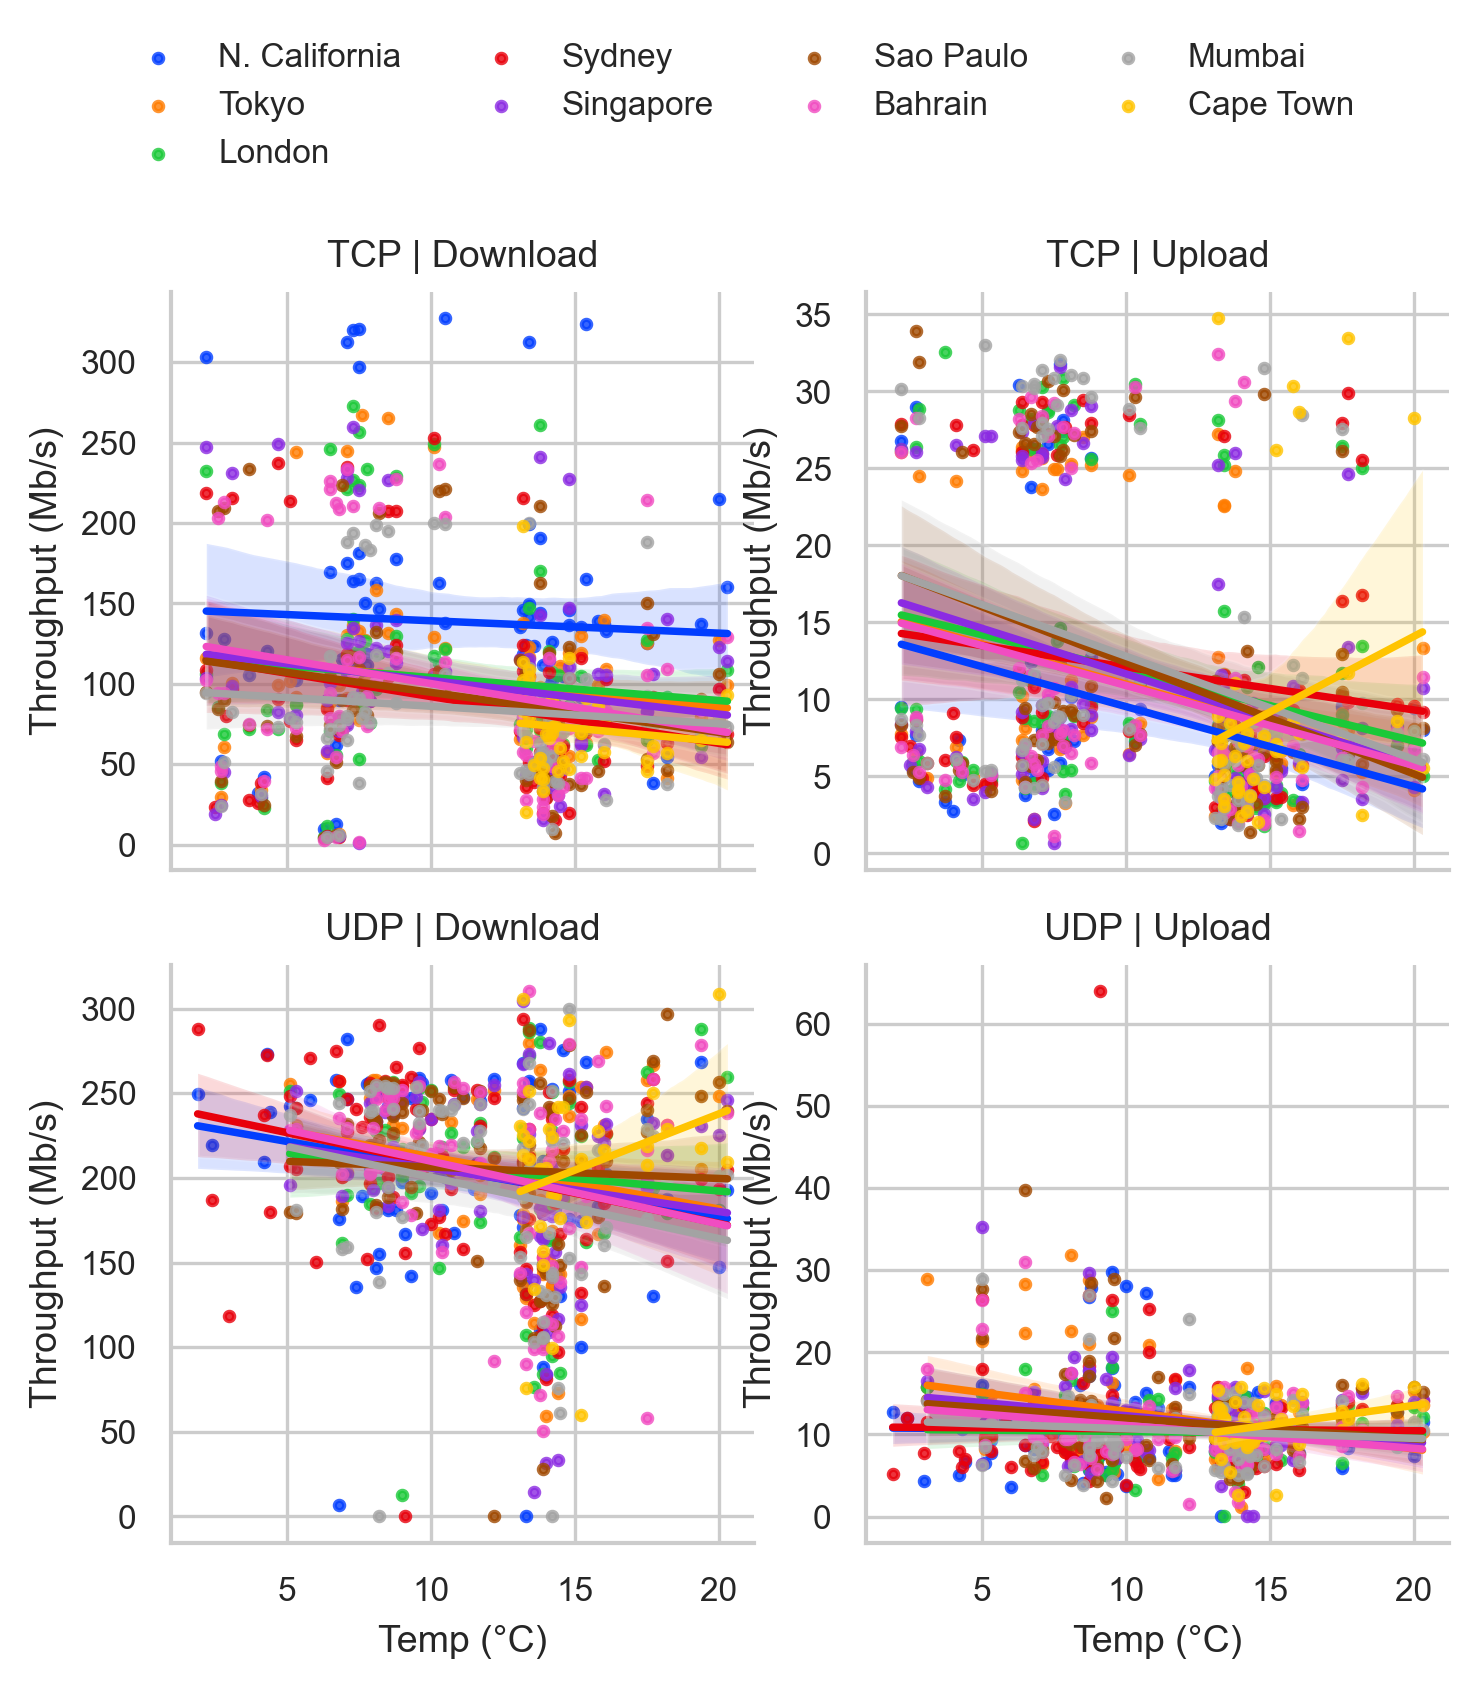

In [261]:
df_temp = df_weather_iperf[
    (df_weather_iperf[N_TYPE] == N_STARLINK)
]
    
g_weather_regress = sns.lmplot(
    data=df_temp,
    x='Temp (°C)', y='bandwidth',
    col=COL_TRANSF_DIR, 
    row=N_PROTOCOL,
    hue=N_REGIONS, hue_order=common.REGION_ORDER,
    #hue=N_PROTOCOL, hue_order=[N_TCP, N_UDP],
    height=2.5, aspect=1,
    #x_estimator=np.mean,
    facet_kws=dict(legend_out=False, sharey=False),
    scatter_kws=dict(s=5),
    #line_kws=dict(color='r'),
)

g_weather_regress.set(ylabel="Throughput (Mb/s)")
g_weather_regress.set_titles(col_template="{col_name}", row_template='{row_name}')
sns.move_legend(g_weather_regress, loc='lower center',
               bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)

#for label in ax.get_xticklabels():
#    label.set_rotation(45)
#    label.set_ha('right')

#ax.set_xlabel("Day of Month (2022)")
#ax.set_ylabel("Jitter (m)")

#plt.savefig(f'{args.filename}.eps', format='eps', bbox_inches='tight')

In [238]:
g_weather_regress.savefig(os.path.join(
    OUTPUT_FOLDER, 'iperf3_weather_corr_2022-06-05_end.pdf'), bbox_inches='tight')

In [297]:
df_temp = df_weather_iperf[
    (df_weather_iperf[N_TYPE] == N_STARLINK)
]
df_temp = df_temp.pivot_table(
    index='Precip. Amount (mm)', 
    columns=[COL_TRANSF_DIR,N_PROTOCOL], values='bandwidth').sort_index()
#df_temp[(df_temp[N_PROTOCOL] == N_UDP) & (df_temp['Precip. Amount (mm)'] == 0)]
print(df_temp)
print(df_temp[df_temp.index > 0].mean())
(df_temp[df_temp.index > 0].mean() / df_temp[df_temp.index == 0])

Transfer Direction     Download                 Upload           
Protocol                    TCP         UDP        TCP        UDP
Precip. Amount (mm)                                              
0.0                  108.022494  215.730397  11.489852  11.516656
0.1                   81.334002  187.276567  16.406245   5.930753
0.2                   56.769866  182.591260   5.097869   9.964943
0.4                   40.970304  162.151421  12.137915   8.688413
0.5                   64.841756  101.272328   3.923983   7.989359
0.6                   55.377863  124.735105   6.541551   8.915455
0.8                   74.772745  180.973127   5.106339   9.071928
0.9                         NaN  218.461419        NaN   9.484814
1.0                         NaN  225.458934        NaN  10.360485
1.1                   76.454139  136.971967   5.937792   8.667714
1.2                         NaN  243.778370        NaN  13.196923
1.3                   88.887212  133.255344  13.210480  13.575316
1.9       

Transfer Direction   Download              Upload          
Protocol                  TCP       UDP       TCP       UDP
Precip. Amount (mm)                                        
0.0                  0.616624  0.748474  0.778043  0.789695

In [132]:
df_weather_iperf.to_csv(f'{OUTPUT_FOLDER}/weather_iperf.csv')

/home/sami/.local/share/virtualenvs/starlink-plot-RhHgxjja/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


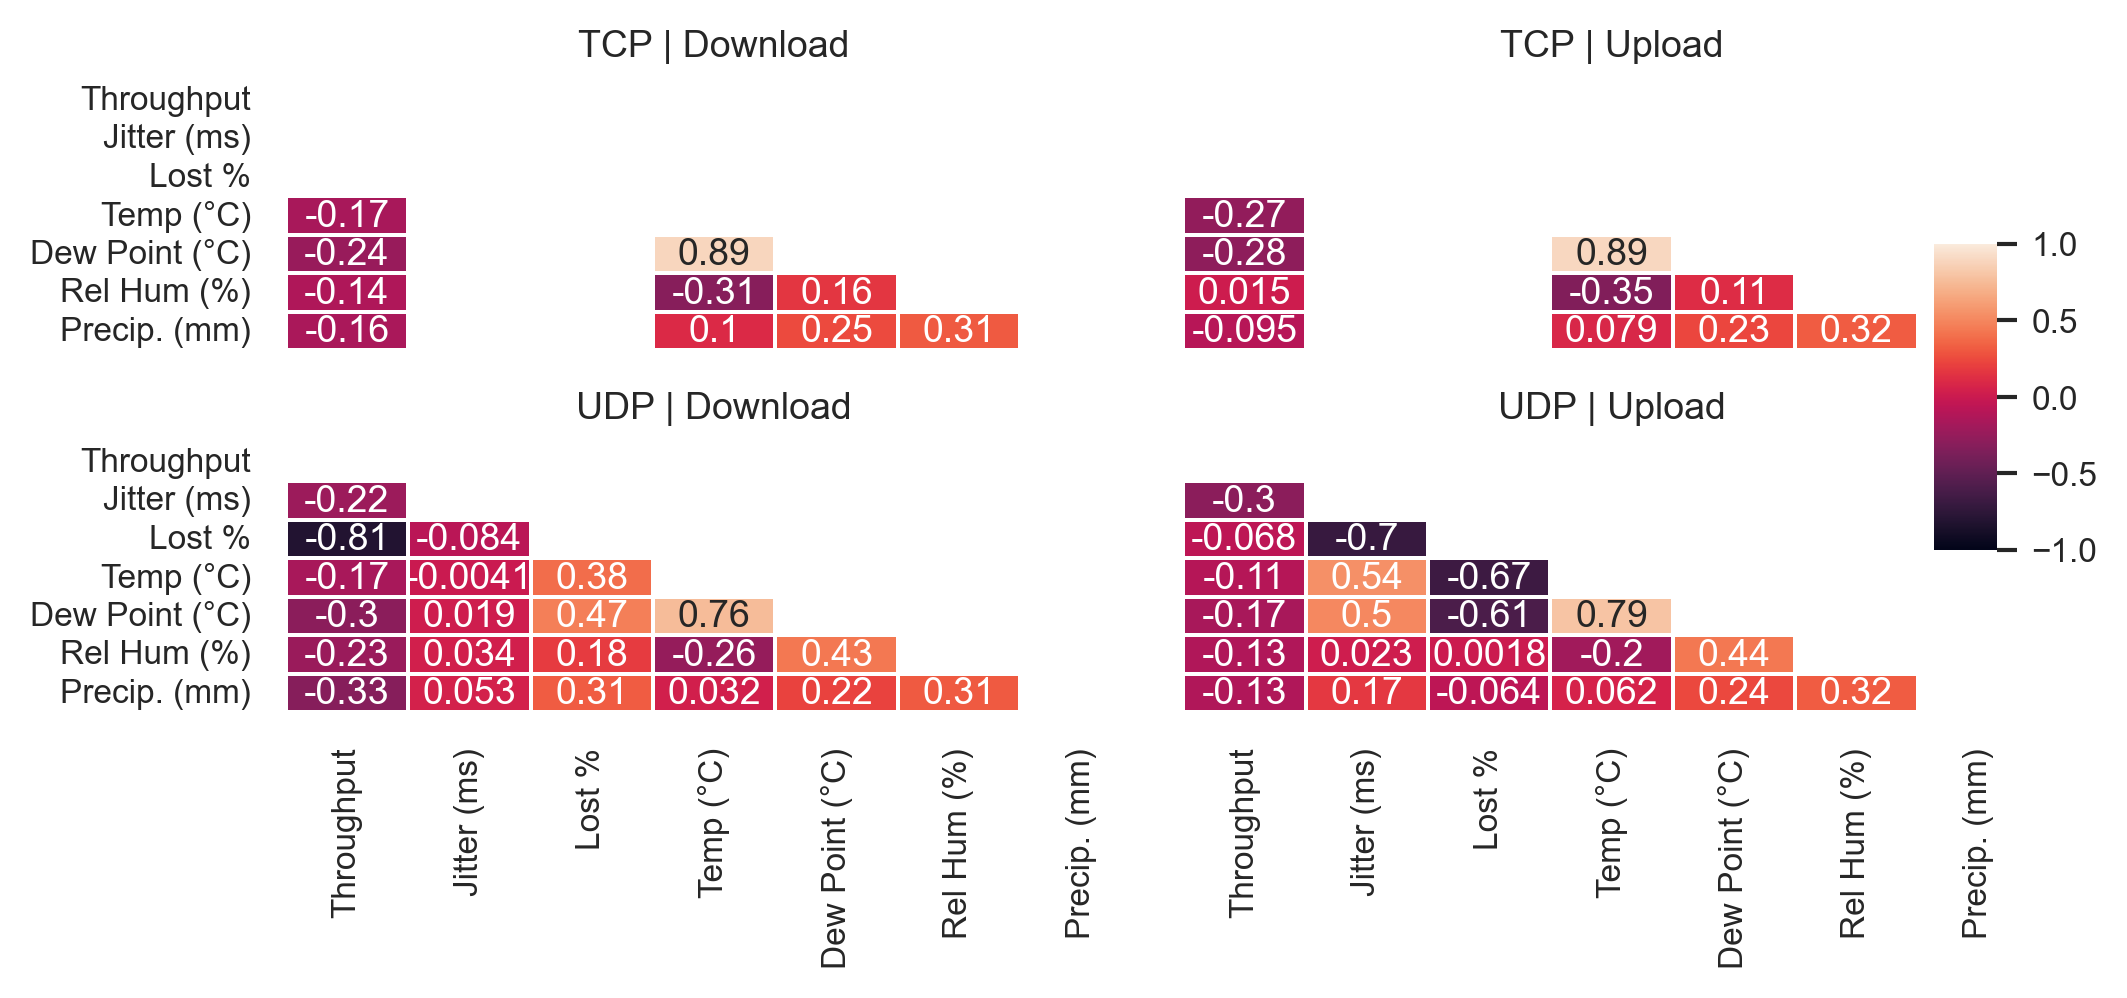

In [253]:
df_temp1 = df_weather_iperf.iloc[:,0:12]
df_temp2 = df_weather_iperf.iloc[:,21:]
df_temp = pd.concat([df_temp1, df_temp2], axis=1)
df_temp = df_temp[
    (df_weather_iperf[N_TYPE] == N_STARLINK)
].drop(['lost_packets', 'packets'], axis=1)

name_map = {
    'bandwidth': 'Throughput',
    'jitter_ms': 'Jitter (ms)',
    'lost_percent': 'Lost %',
    'Dew Point Temp (°C)': 'Dew Point (°C)',
    'Precip. Amount (mm)': 'Precip. (mm)'
}

df_temp = df_temp.rename(columns=name_map).drop(N_THROUGHPUT_OUTLIERS, axis=1)
            

keep_cols = ['Throughput', 'Jitter (ms)', 'Lost %', 'Temp (°C)',
             'Dew Point (°C)', 'Rel Hum (%)', 'Precip. (mm)']
def draw_corr(*args, **kwargs):
    df = kwargs.pop('data')
    corr = df[keep_cols].corr()
    #corr = corr.drop(keep_cols[3:], axis=1)
    #corr = corr.dropna(how='all')
    #corr = corr.drop(keep_cols[0], axis=0)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, **kwargs)

g_corr_map = sns.FacetGrid(
    data=df_temp,
    col=COL_TRANSF_DIR,
    row=N_PROTOCOL,
    aspect=2.05,
    height=1.7,
    sharey='row',
)
cbar_ax = g_corr_map.figure.add_axes([.93, .45, .03, .3])
g_corr_map.map_dataframe(
    draw_corr, 
    linewidths=.5,
    vmin=-1, vmax=1,
    cbar_ax=cbar_ax,
    #cbar_kws={"shrink": .5},
    annot=True,
)
axes = g_corr_map.axes.flatten()
#axes[0].set_yticklabels(keep_cols[3:])
#axes[1].set_yticklabels(keep_cols[3:])

g_corr_map.set_titles(col_template="{col_name}", row_template="{row_name}")
g_corr_map.set(ylabel='')

g_corr_map.tight_layout()

In [361]:
df_temp = df_regs.copy()
df_temp = df_temp[
    (df_temp[N_TYPE] == N_STARLINK)
].drop(['lost_packets', 'packets'], axis=1)
df_temp1 = df_temp[df_temp[COL_PARAID].isna()]
df_temp2 = df_temp[df_temp[COL_PARAID].notna()]
df_temp2 = df_temp2.groupby(['timestamp', N_PROTOCOL, COL_TRANSF_DIR]).agg(
    {
        'snd_cwnd': 'sum',
        'retransmits': 'sum',
        'bandwidth': 'mean',
        'jitter_ms': 'mean',
        'lost_percent': 'mean',
        'rtt': 'mean',
        'rttvar': 'mean',
    }
).reset_index()

df_tcp_agg = pd.concat([df_temp1, df_temp2])
df_tcp_agg.groupby(['timestamp', N_PROTOCOL, COL_TRANSF_DIR]).mean().reset_index()

,timestamp,Protocol,Transfer Direction,bandwidth,jitter_ms,lost_percent,snd_cwnd,rtt,rttvar,retransmits,parallel ID
0,2022-01-23 04:35:13.000114944,TCP,Upload,1.836197,NaN,NaN,237472.0,233300.75,4321.25,0.0,NaN
1,2022-01-23 04:35:14.000139008,TCP,Upload,2.444667,NaN,NaN,288152.0,242250.25,4804.00,0.0,NaN
2,2022-01-23 04:35:15.000401920,TCP,Upload,2.769705,NaN,NaN,296840.0,241020.25,7081.75,4.0,NaN
3,2022-01-23 04:35:16.000116224,TCP,Upload,2.229662,NaN,NaN,353312.0,276806.25,7696.00,1.0,NaN
4,2022-01-23 04:35:16.000148992,TCP,Download,15.578690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
319309,2022-07-08 03:18:03.000161792,UDP,Download,213.182237,0.110901,39.417284,NaN,NaN,NaN,NaN,NaN
319310,2022-07-08 03:18:04.000071168,UDP,Upload,7.101021,0.943322,89.028101,NaN,NaN,NaN,NaN,NaN
319311,2022-07-08 03:18:04.000098816,UDP,Download,229.594838,0.161055,34.412018,NaN,NaN,NaN,NaN,NaN
319312,2022-07-08 03:18:05.000067072,UDP,Upload,8.942731,0.902654,83.872989,NaN,NaN,NaN,NaN,NaN


/home/sami/.local/share/virtualenvs/starlink-plot-RhHgxjja/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


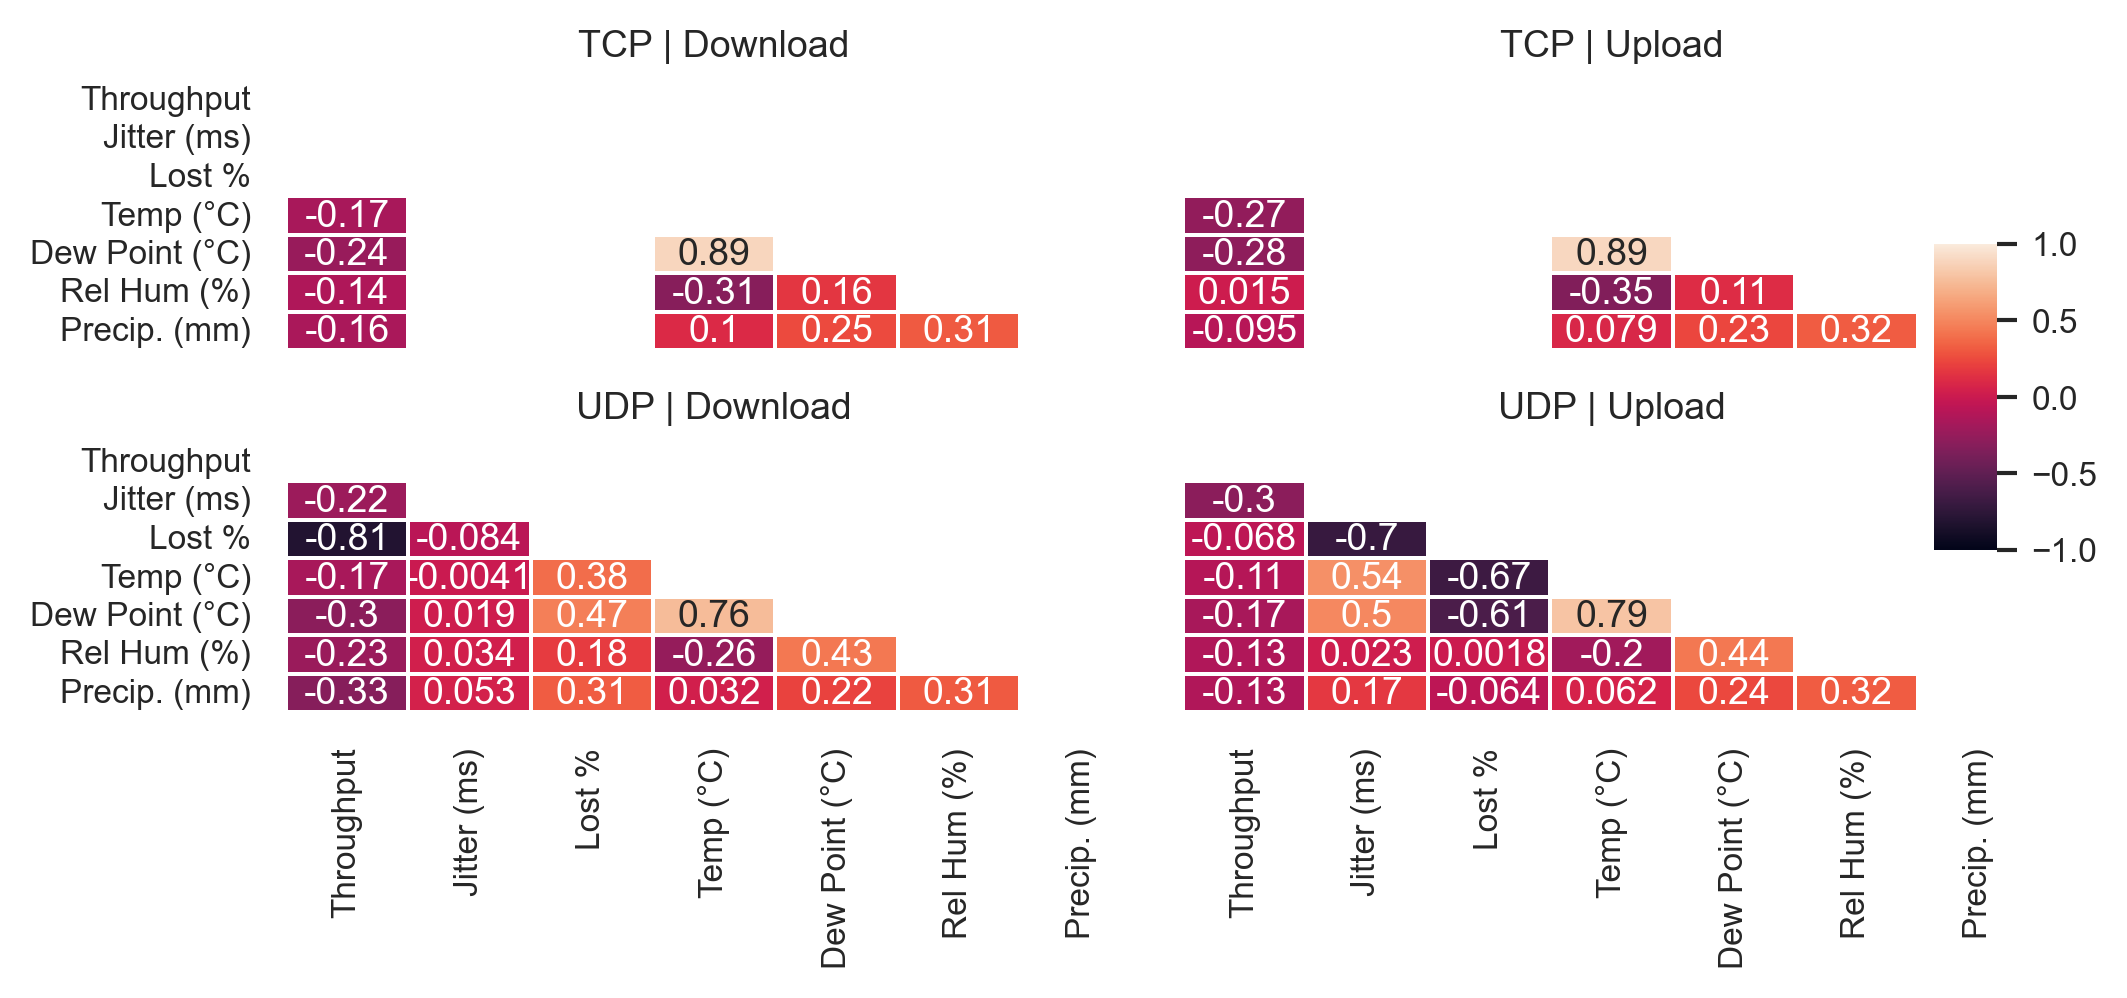

In [253]:
df_temp = df_regs.copy()
df_temp = df_temp[
    (df_temp[N_TYPE] == N_STARLINK)
].drop(['lost_packets', 'packets'], axis=1)

name_map = {
    'bandwidth': 'Throughput',
    'jitter_ms': 'Jitter (ms)',
    'lost_percent': 'Lost %',
    'Dew Point Temp (°C)': 'Dew Point (°C)',
    'Precip. Amount (mm)': 'Precip. (mm)'
}

df_temp = df_temp.rename(columns=name_map).drop(N_THROUGHPUT_OUTLIERS, axis=1)
            

keep_cols = ['Throughput', 'Jitter (ms)', 'Lost %', 'Temp (°C)',
             'Dew Point (°C)', 'Rel Hum (%)', 'Precip. (mm)']
def draw_corr(*args, **kwargs):
    df = kwargs.pop('data')
    corr = df[keep_cols].corr()
    #corr = corr.drop(keep_cols[3:], axis=1)
    #corr = corr.dropna(how='all')
    #corr = corr.drop(keep_cols[0], axis=0)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, **kwargs)

g_corr_map = sns.FacetGrid(
    data=df_temp,
    col=COL_TRANSF_DIR,
    row=N_PROTOCOL,
    aspect=2.05,
    height=1.7,
    sharey='row',
)
cbar_ax = g_corr_map.figure.add_axes([.93, .45, .03, .3])
g_corr_map.map_dataframe(
    draw_corr, 
    linewidths=.5,
    vmin=-1, vmax=1,
    cbar_ax=cbar_ax,
    #cbar_kws={"shrink": .5},
    annot=True,
)
axes = g_corr_map.axes.flatten()
#axes[0].set_yticklabels(keep_cols[3:])
#axes[1].set_yticklabels(keep_cols[3:])

g_corr_map.set_titles(col_template="{col_name}", row_template="{row_name}")
g_corr_map.set(ylabel='')

g_corr_map.tight_layout()

In [240]:
g_corr_map.savefig(f'{OUTPUT_FOLDER}/iperf3_weather_corr_heatmap_2022-06-05_end.pdf', bbox_inches='tight')

In [197]:
#df_temp[(df_temp[N_PROTOCOL] == N_TCP) & (df_temp['Jitter (ms)'] > 0)]
df_temp.columns

Index(['Type', 'Regions', 'Protocol', 'Protocol and Type',
       'Transfer Direction', 'timestamp', 'Throughput', 'Jitter (ms)',
       'Lost %', 'Temp (°C)', 'Temp Flag', 'Dew Point (°C)',
       'Dew Point Temp Flag', 'Rel Hum (%)', 'Rel Hum Flag', 'Precip. (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather'],
      dtype='object')

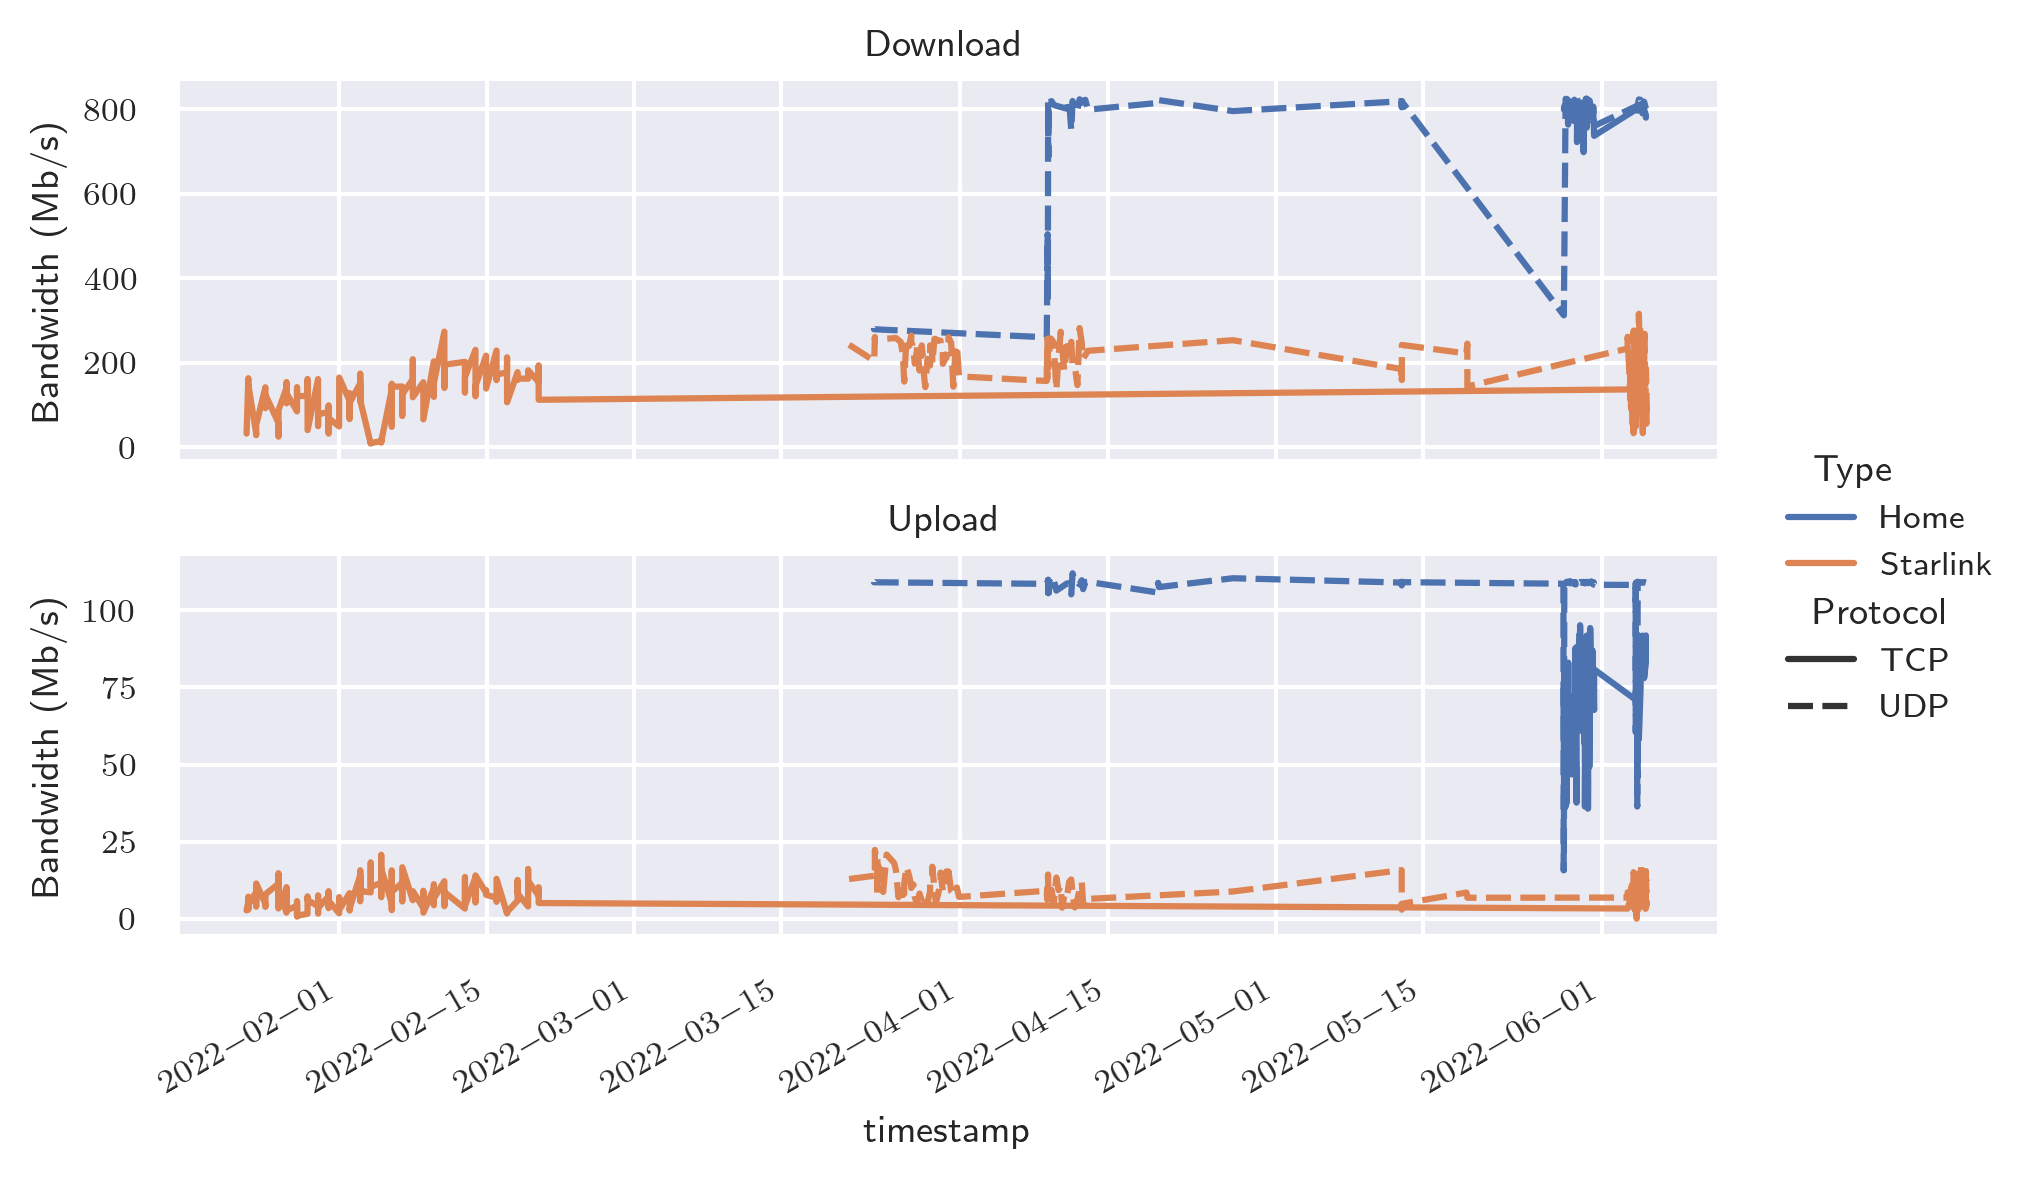

In [58]:
#fig, ax = plt.subplots(figsize=(3.5,3))
#fig, ax = plt.subplots(figsize=(20,10))

#ax.xaxis.update_units(df.index)
#y_val = df_unstacked.bandwidth
#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

temp = df_regs_interp
temp = temp.fillna(np.inf)
#temp = temp[temp['timestamp'] > '2022-06-02']
temp = temp[temp[N_REGIONS] == 'N. California']
#g = sns.relplot(data=temp, row=COL_TRANSF_DIR, hue=N_REGIONS,
#                style=COL_PROT_TYPE, style_order=PROT_TYPE_ORDER,
#                height=2, aspect=2.98,
#                kind='line',
#                x = 'timestamp', y='bandwidth',
#                facet_kws={'sharey': False})

g = sns.relplot(data=temp, row=COL_TRANSF_DIR, hue=N_TYPE,
                style=N_PROTOCOL,
                height=2, aspect=2.98,
                kind='line',
                x = 'timestamp', y='bandwidth',
                facet_kws={'sharey': False})

#g_ax = g.fig.axes
#sns.scatterplot(data=df_outage, ax=g_ax)


#g = sns.lineplot(data=df_unstacked, x='timestamp', y='bandwidth', hue=N_REGIONS, style=N_TYPE)
#g = sns.lineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')

g.figure.autofmt_xdate()

#ax.set_ylabel("Jitter (ms)")
g.set_titles(row_template="{row_name}")
g.set(ylabel="Throughput (Mb/s)")
#g.set(yscale="log")
g.tight_layout()
#fig.tight_layout()

In [136]:
df_star = df_regs[df_regs[N_TYPE] == N_STARLINK]
df_star[df_star[N_PROTOCOL] == N_TCP].sort_values('timestamp')
#df_regs_interp.sort_values('timestamp')

,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,Regions,Protocol,Transfer Direction,Type,Protocol and Type
97058,2022-01-23 04:35:16.000116224,8.918949,NaN,NaN,NaN,NaN,Sydney,TCP,Upload,Starlink,TCP Starlink
131372,2022-01-23 04:35:16.000148992,15.578690,NaN,NaN,NaN,NaN,Sydney,TCP,Download,Starlink,TCP Starlink
98171,2022-01-23 04:35:17.000197888,9.353438,NaN,NaN,NaN,NaN,Sydney,TCP,Upload,Starlink,TCP Starlink
141419,2022-01-23 04:35:17.000263936,19.361028,NaN,NaN,NaN,NaN,Sydney,TCP,Download,Starlink,TCP Starlink
146501,2022-01-23 04:35:18.000048896,23.225289,NaN,NaN,NaN,NaN,Sydney,TCP,Download,Starlink,TCP Starlink
...,...,...,...,...,...,...,...,...,...,...,...
11793,2022-06-05 05:14:27.000739072,0.000000,NaN,NaN,NaN,NaN,Cape Town,TCP,Upload,Starlink,TCP Starlink
222200,2022-06-05 05:14:28.000099840,92.677458,NaN,NaN,NaN,NaN,Cape Town,TCP,Download,Starlink,TCP Starlink
18791,2022-06-05 05:14:28.001073152,1.564906,NaN,NaN,NaN,NaN,Cape Town,TCP,Upload,Starlink,TCP Starlink
213915,2022-06-05 05:14:29.000040960,85.148361,NaN,NaN,NaN,NaN,Cape Town,TCP,Download,Starlink,TCP Starlink


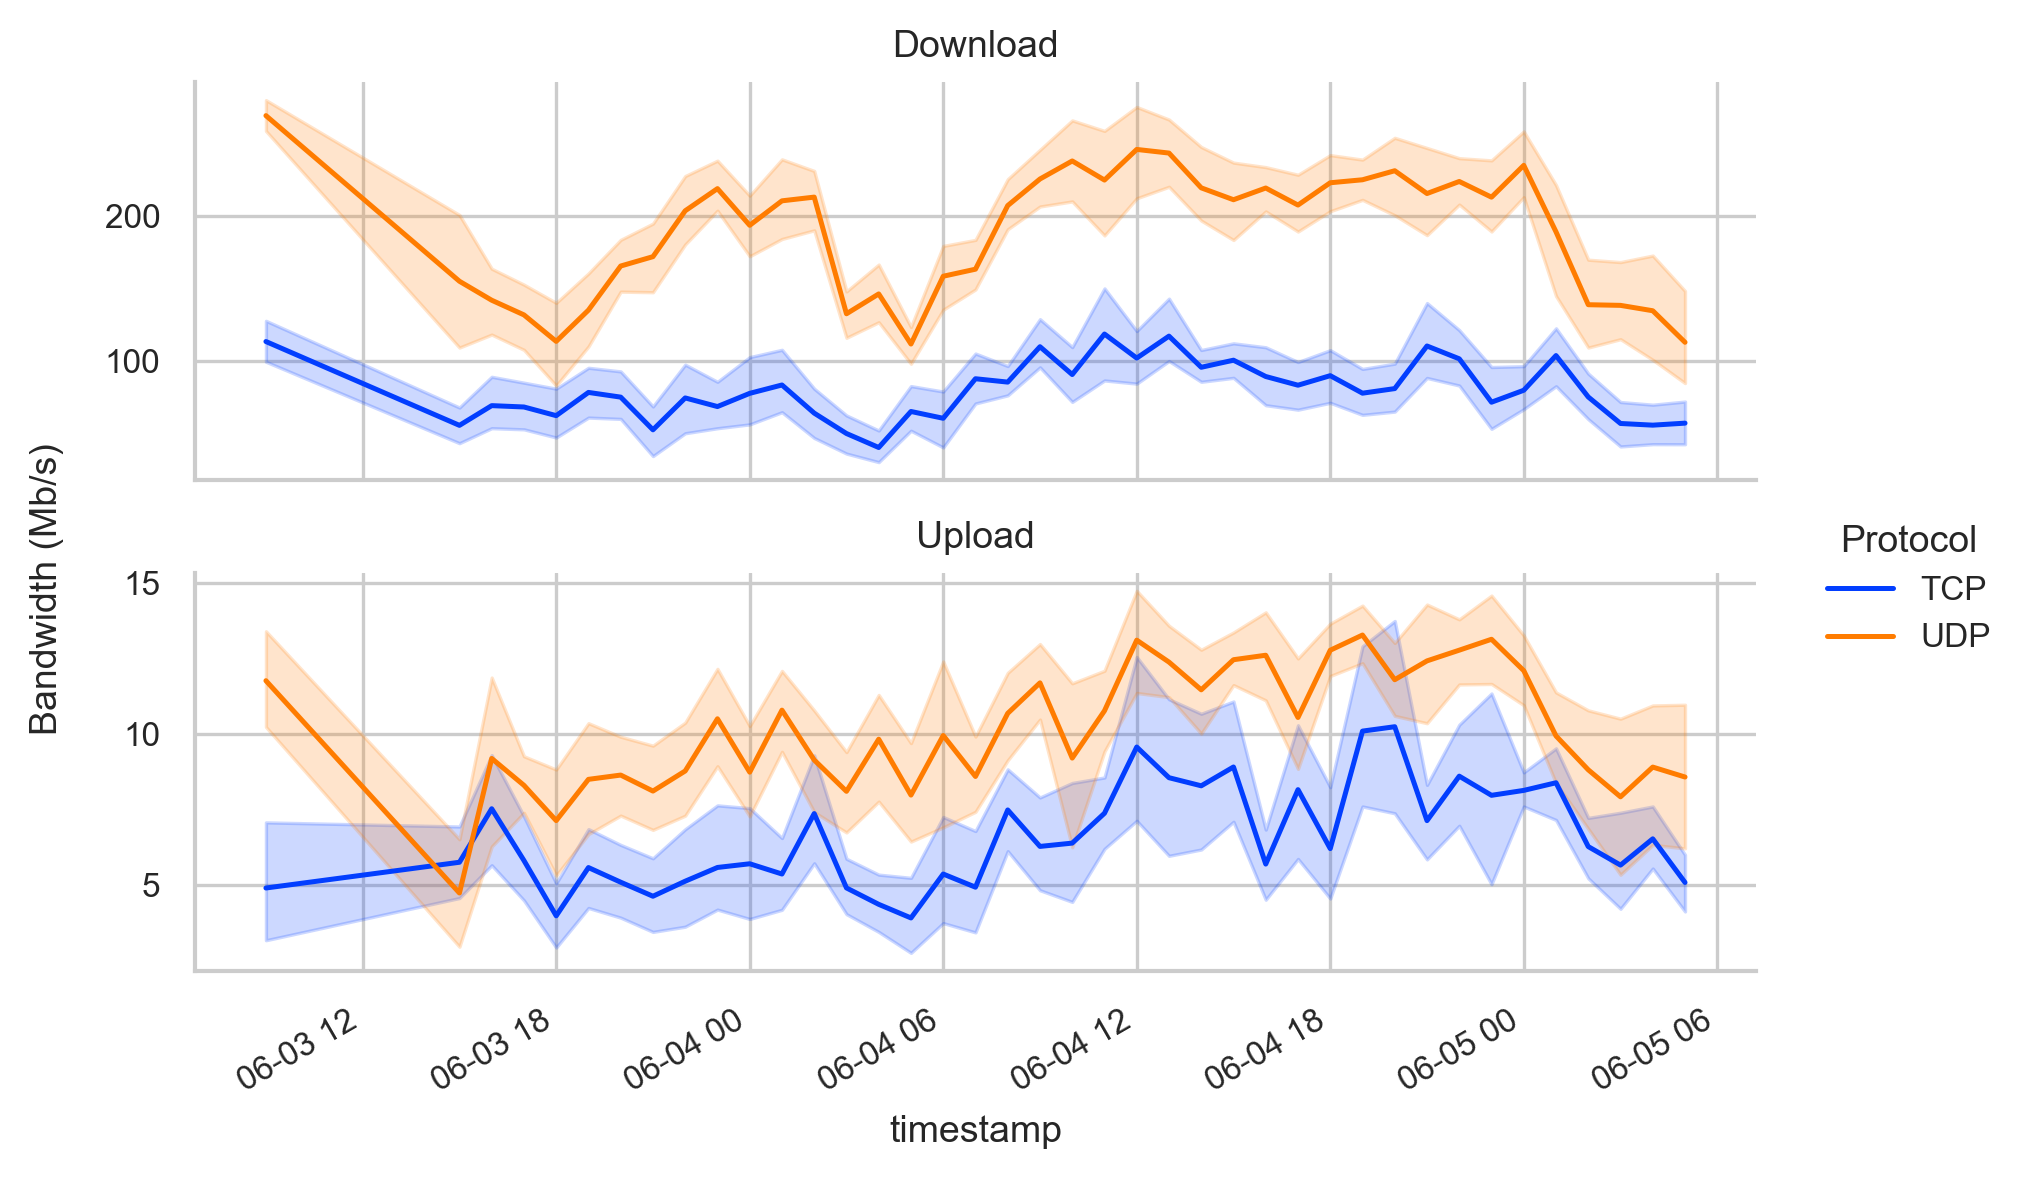

In [34]:
temp = df_regs_interp.copy()
temp = temp[temp['timestamp'] > '2022-06-02']
temp = temp[temp[N_TYPE] == N_STARLINK]
#temp = temp[temp[N_PROTOCOL] == N_TCP]
temp['Day'] = temp.timestamp.dt.day

g_pat = sns.relplot(data=temp, row=COL_TRANSF_DIR,
                    hue=N_PROTOCOL,# style=N_PROTOCOL,
                    height=2, aspect=3.045,
                    kind='line',
                    x='timestamp', y='bandwidth',
                    facet_kws={'sharey': False})

g_pat.figure.autofmt_xdate()

g_pat.set_titles(row_template="{row_name}")
g_pat.set(ylabel="")
g_pat.figure.supylabel('Throughput (Mb/s)')
g_pat.tight_layout()

Day                          2          3          4          5          6
Transfer Direction                                                        
Download            107.592761   5.135047   6.388245  94.702639  90.205302
Upload                8.586459  11.634567  12.610558   8.401463   6.594147


Text(0.02, 0.5, 'Throughput (Mb/s)')

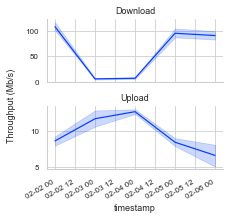

In [24]:
temp = df_regs_interp.copy()
temp = temp[(temp['timestamp'] >= '2022-02-02') & (temp['timestamp'] <= '2022-02-06')]
temp = temp[temp[N_TYPE] == N_STARLINK]
temp = temp[temp[N_PROTOCOL] == N_TCP]
#temp = temp[temp[COL_TRANSF_DIR] == N_DOWN]
temp['Day'] = temp.timestamp.dt.day
print(temp.pivot_table(index=COL_TRANSF_DIR, columns='Day', values='bandwidth'))

g_single = sns.relplot(data=temp, 
                    row=COL_TRANSF_DIR, row_order=[N_DOWN, N_UP],
                    #hue=N_REGIONS, hue_order=common.REGION_ORDER,
                    # style=N_PROTOCOL,
                    height=1.5, aspect=2.2,
                    kind='line',
                    x='timestamp', y='bandwidth',
                    facet_kws={'sharey': False})

g_single.figure.autofmt_xdate()

g_single.set_titles(row_template="{row_name}")
g_single.set(ylabel="")
g_single.figure.supylabel('Throughput (Mb/s)')


In [25]:
g_single.savefig(f'{OUTPUT_FOLDER}/2022-02-02_starlink_throughput_outage.pdf', bbox_inches='tight')

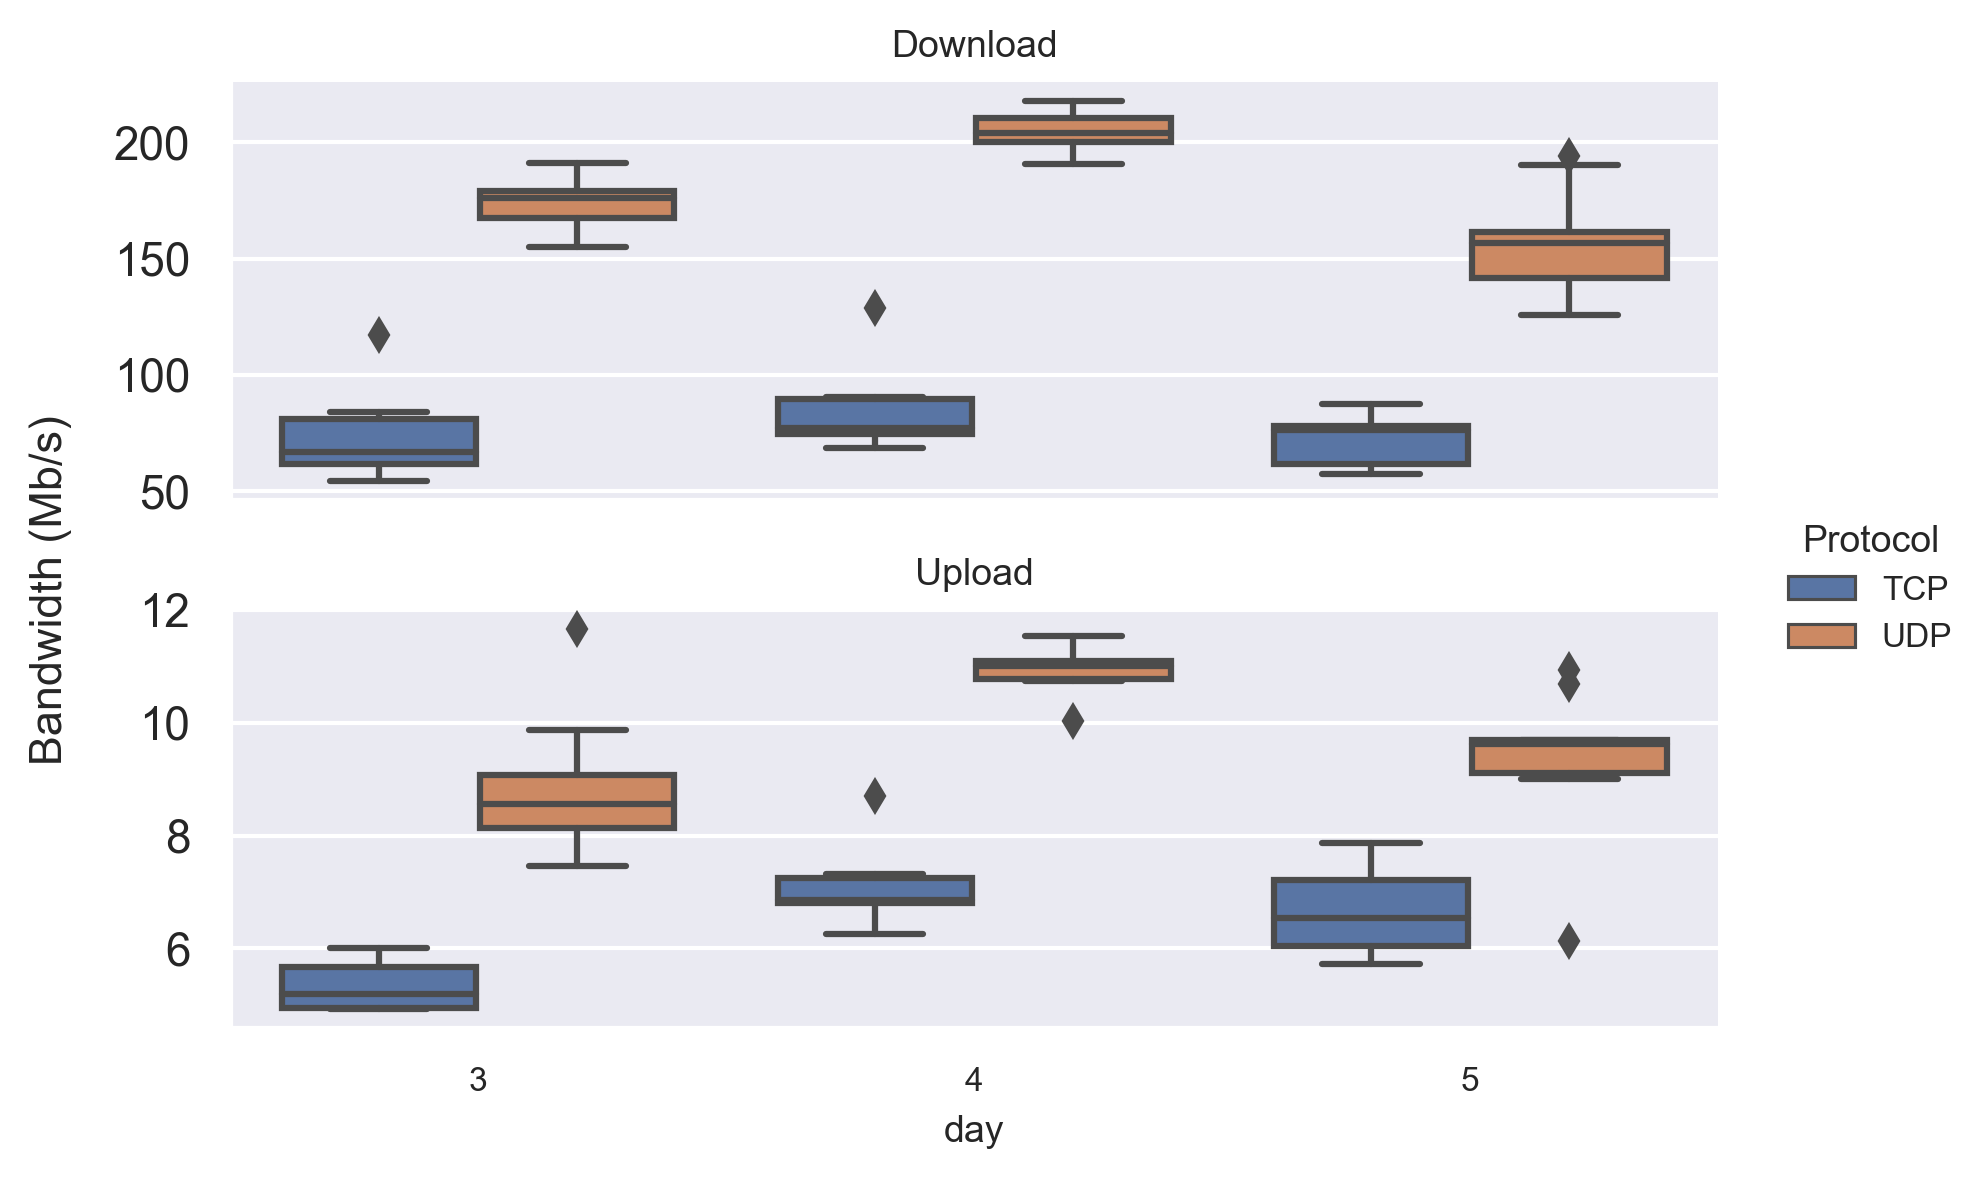

In [80]:
temp = df_regs_interp
temp = temp[temp['timestamp'] > '2022-06-02']
temp = temp[temp[N_TYPE] == N_STARLINK]
temp['day'] = temp.timestamp.dt.day

g_pat = sns.catplot(data=temp, row=COL_TRANSF_DIR,
                    hue=N_PROTOCOL,# style=N_PROTOCOL,
                    height=2, aspect=2.98,
                    kind='box', sharey=False,
                    x='day', y='bandwidth')

#g_pat.figure.autofmt_xdate()

g_pat.set_titles(row_template="{row_name}")
g_pat.set(ylabel="")
g_pat.figure.supylabel('Throughput (Mb/s)')
g_pat.tight_layout()

In [ ]:
from matplotlib.patches import Rectangle
g_bar = sns.catplot(data=df_regs,
                    col=N_PROTOCOL,
                    x=N_REGIONS, y='bandwidth',hue=N_TYPE,
                    ci='sd', 
                    kind='bar', legend=False,
                    height=2, aspect=1.79, col_wrap=2)

#g_bar.set_xticklabels(['TD', 'TU', 'UD', 'UU'])
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
g_bar.figure.autofmt_xdate()
g_bar.set_titles(col_template="{col_name}")
g_bar.axes.flatten()[1].legend()
#g_bar.add_legend(loc='upper right')
#g_bar.figure.legend([extra, extra, extra, extra], 
#                    ('TD = TCP Download','TU = TCP Upload', 
#                     'UD = UDP Download', 'UU = UDP Upload'),
#                   frameon=False, loc='lower right')
g_bar.set(ylabel="Throughput (Mb/s)")
g_bar.tight_layout()

In [165]:
g_bar.savefig(os.path.join(OUTPUT_FOLDER, 'throughput_summary.pgf'), bbox_inches='tight')

In [219]:
df_downs_only = df_regs[df_regs[N_PROTOCOL].isin([TCP_DOWN, UDP_DOWN])]
df_downs_only[df_downs_only[[N_PROTOCOL, N_REGIONS]].agg('-'.join, axis=1)

0                TCP Down-Mumbai
1                TCP Down-Sydney
2                TCP Down-Sydney
3                TCP Down-Sydney
4                TCP Down-Sydney
                   ...          
112355    UDP Down-N. California
112356    UDP Down-N. California
112357    UDP Down-N. California
112358    UDP Down-N. California
112359    UDP Down-N. California
Length: 73091, dtype: object

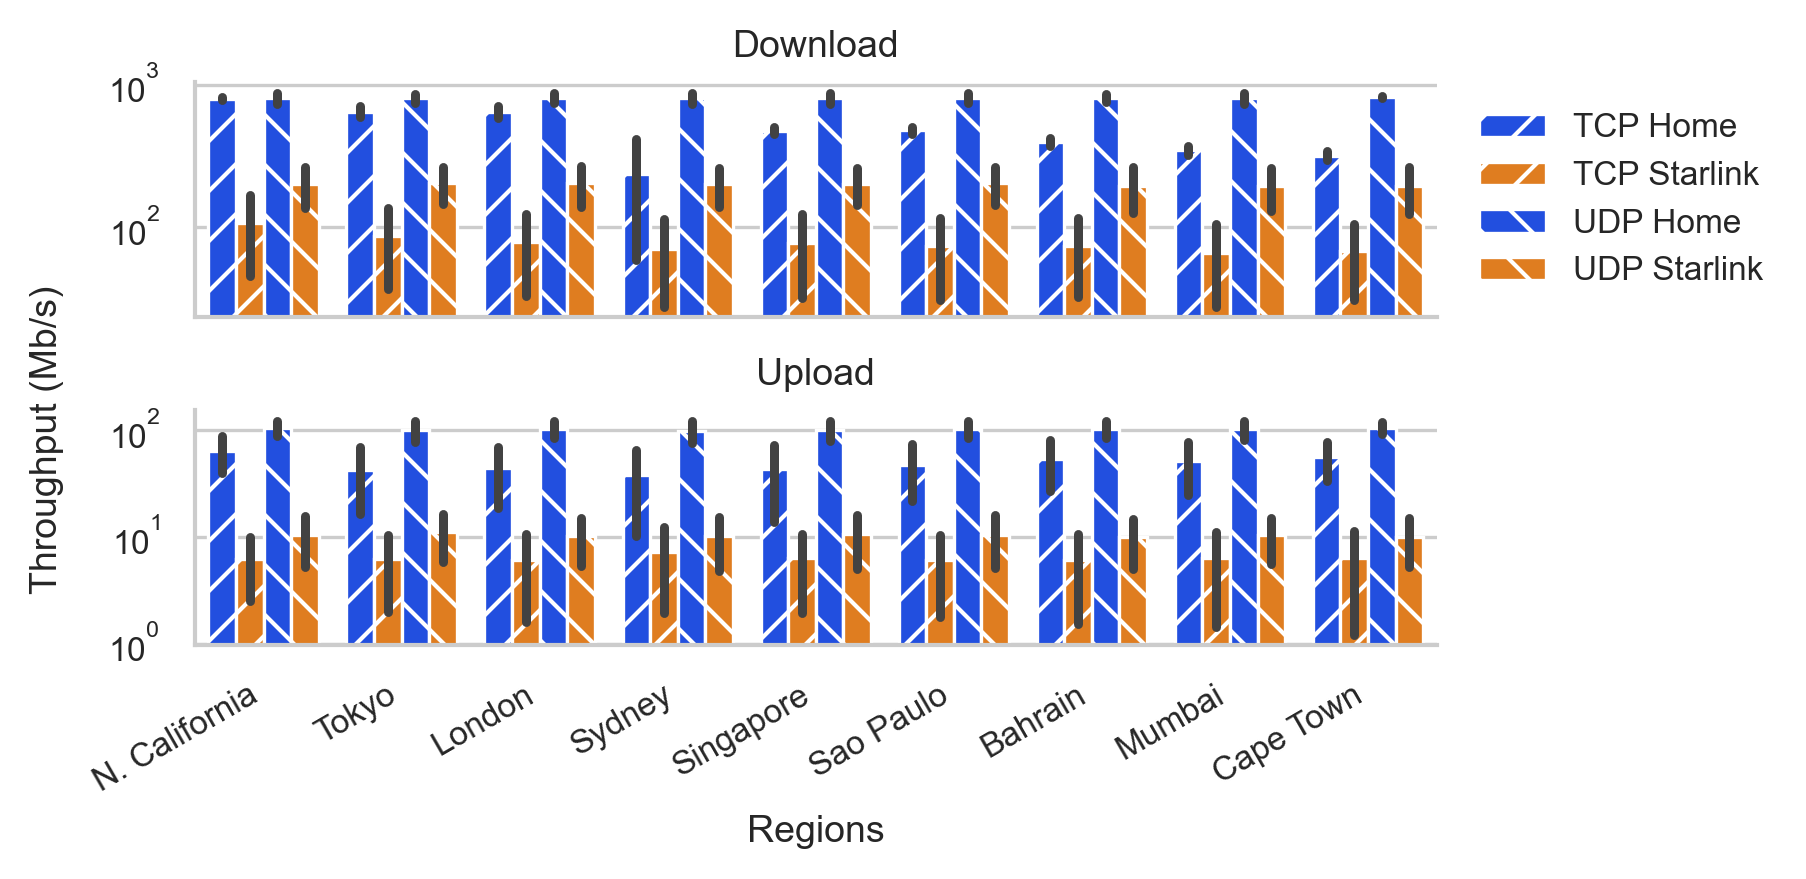

In [331]:
#temp = df_regs.loc['2022-06-03':]
#sns.set_palette('bright')
g_avg = sns.catplot(data=df_regs[df_regs['parallel ID'].isna()],
                    row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_REGIONS, y='bandwidth', hue=COL_PROT_TYPE,
                    hue_order=PROT_TYPE_ORDER, row_order=[N_DOWN, N_UP],
                    order=common.REGION_ORDER,
                    legend=False,
                    palette=['C0', 'C1', 'C0', 'C1'],
                    kind='bar', ci='sd',
                    height=1.5, aspect=4.06)

num_locs = len(df_regs[N_REGIONS].unique())
hatches = itertools.cycle(['//','//', '\\\\', '\\\\'])
axes = g_avg.axes.flatten()
for ax in axes:
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

axes[0].legend(loc='lower left', bbox_to_anchor=(1.01,0), fancybox=True, frameon=False)
g_avg.figure.autofmt_xdate()
g_avg.set_titles(row_template="{row_name}")
g_avg.set(ylabel="")
g_avg.figure.supylabel("Throughput (Mb/s)", fontsize=9)
g_avg.tight_layout()

In [337]:
g_avg.savefig(os.path.join(OUTPUT_FOLDER, '2022-07-08_end_avg_throughput.pdf'), bbox_inches='tight')

In [339]:
df_avg_regs = df_regs[df_regs[COL_PARAID].isna()].pivot_table(
    index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL, COL_TRANSF_DIR], values=BANDWIDTH
).reindex(common.REGION_ORDER)
styler = df_avg_regs.style
styler.format(precision=2)
styler.to_latex(os.path.join(OUTPUT_FOLDER, 'all_bandwidth.tex'))
df_avg_regs

Type                      Home                                       Starlink  \
Protocol                   TCP                    UDP                     TCP   
Transfer Direction    Download     Upload    Download      Upload    Download   
Regions                                                                         
N. California       798.894281  64.212674  804.967472  104.417166  107.768868   
Tokyo               647.549223  42.693871  807.792850   99.960105   87.284981   
London              644.713961  43.981169  806.907662  103.486765   78.511829   
Sydney              238.384934  37.659416  804.546188   98.669532   70.716130   
Singapore           475.389403  43.250484  805.452512  101.023070   78.113442   
Sao Paulo           481.630750  47.675411  807.844091  103.207801   73.831435   
Bahrain             398.050652  54.072516  810.589963  103.203807   74.488319   
Mumbai              346.690810  51.345364  803.791412  101.650222   66.433163   
Cape Town           318.901913  55.623818  816.026524  105.582805   68.505973   

Type                                                 
Protocol                             UDP             
Transfer Direction    Upload    Download     Upload  
Regions                                              
N. California       6.262161  201.416215  10.410809  
Tokyo               6.243014  205.720970  11.176077  
London              6.083464  203.556060  10.164528  
Sydney              7.158693  200.083203  10.095486  
Singapore           6.333427  202.500429  10.562983  
Sao Paulo           6.126066  205.390896  10.485040  
Bahrain             6.135501  194.268068   9.897429  
Mumbai              6.292338  196.204254  10.331989  
Cape Town           6.341941  193.674441  10.065874

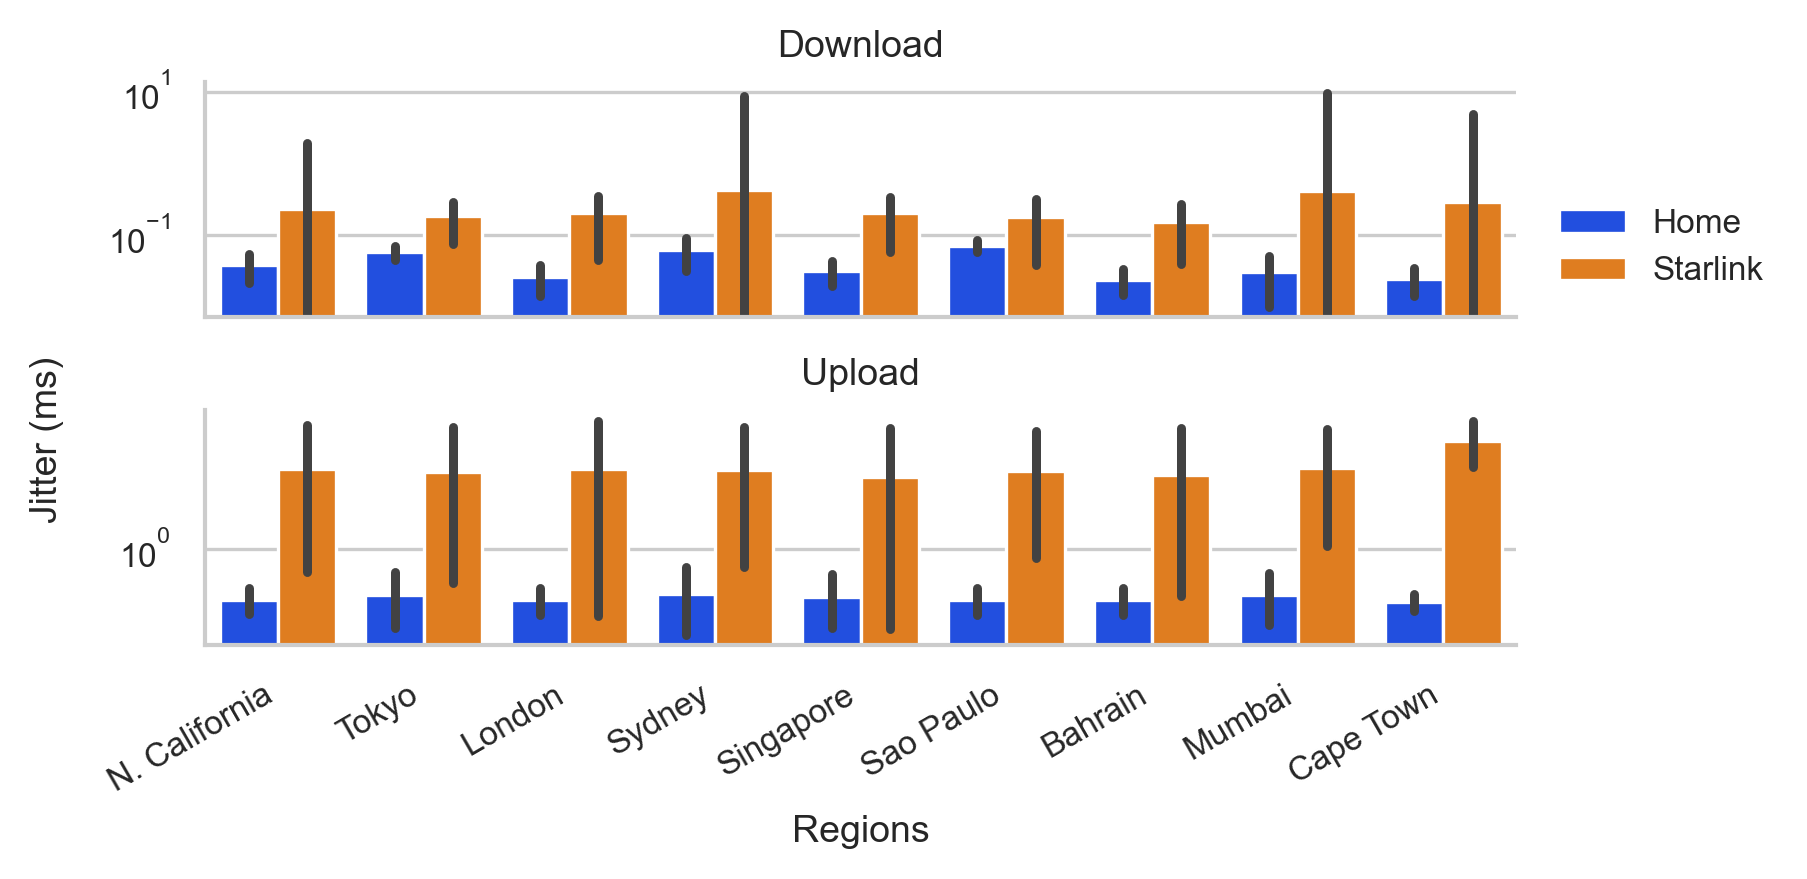

In [27]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('bright')
tmp = df_outliers[(df_outliers[N_TYPE] == N_STARLINK) | (df_outliers[N_THROUGHPUT_OUTLIERS] == False)]
g_jitter = sns.catplot(data=tmp,
                    row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_REGIONS,
                    row_order=[N_DOWN, N_UP],
                    y='jitter_ms', 
                    hue=N_TYPE, hue_order=[N_HOME, N_STARLINK],
                    order=common.REGION_ORDER,
                    legend=False,
                    kind='bar', ci='sd',
                    height=1.5, aspect=4.06)

#num_locs = len(df_regs[N_REGIONS].unique())
#hatches = itertools.cycle(['//', '\\\\'])
axes = g_jitter.axes.flatten()
#for ax in axes:
#    for i, bar in enumerate(ax.patches):
#        if i % num_locs == 0:
#            hatch = next(hatches)
#        bar.set_hatch(hatch)
#        #print(bar.get_facecolor())
#        #bar.set_color(colour)

axes[0].legend(loc='lower left', bbox_to_anchor=(1.01,0), fancybox=True, frameon=False)
g_jitter.figure.autofmt_xdate()
g_jitter.set_titles(row_template="{row_name}")
g_jitter.set(ylabel="")
g_jitter.figure.supylabel("Jitter (ms)", fontsize=9)
g_jitter.tight_layout()

In [28]:
g_jitter.savefig(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_udp_jitter_avg.pdf'), bbox_inches='tight')

In [29]:
tmp.pivot_table(index=COL_TRANSF_DIR, columns=N_TYPE, values='jitter_ms')

Type,Home,Starlink,Starlink Remote
Transfer Direction,,,
Download,0.041103,0.254756,0.925259
Upload,0.545534,2.715160,8.988243


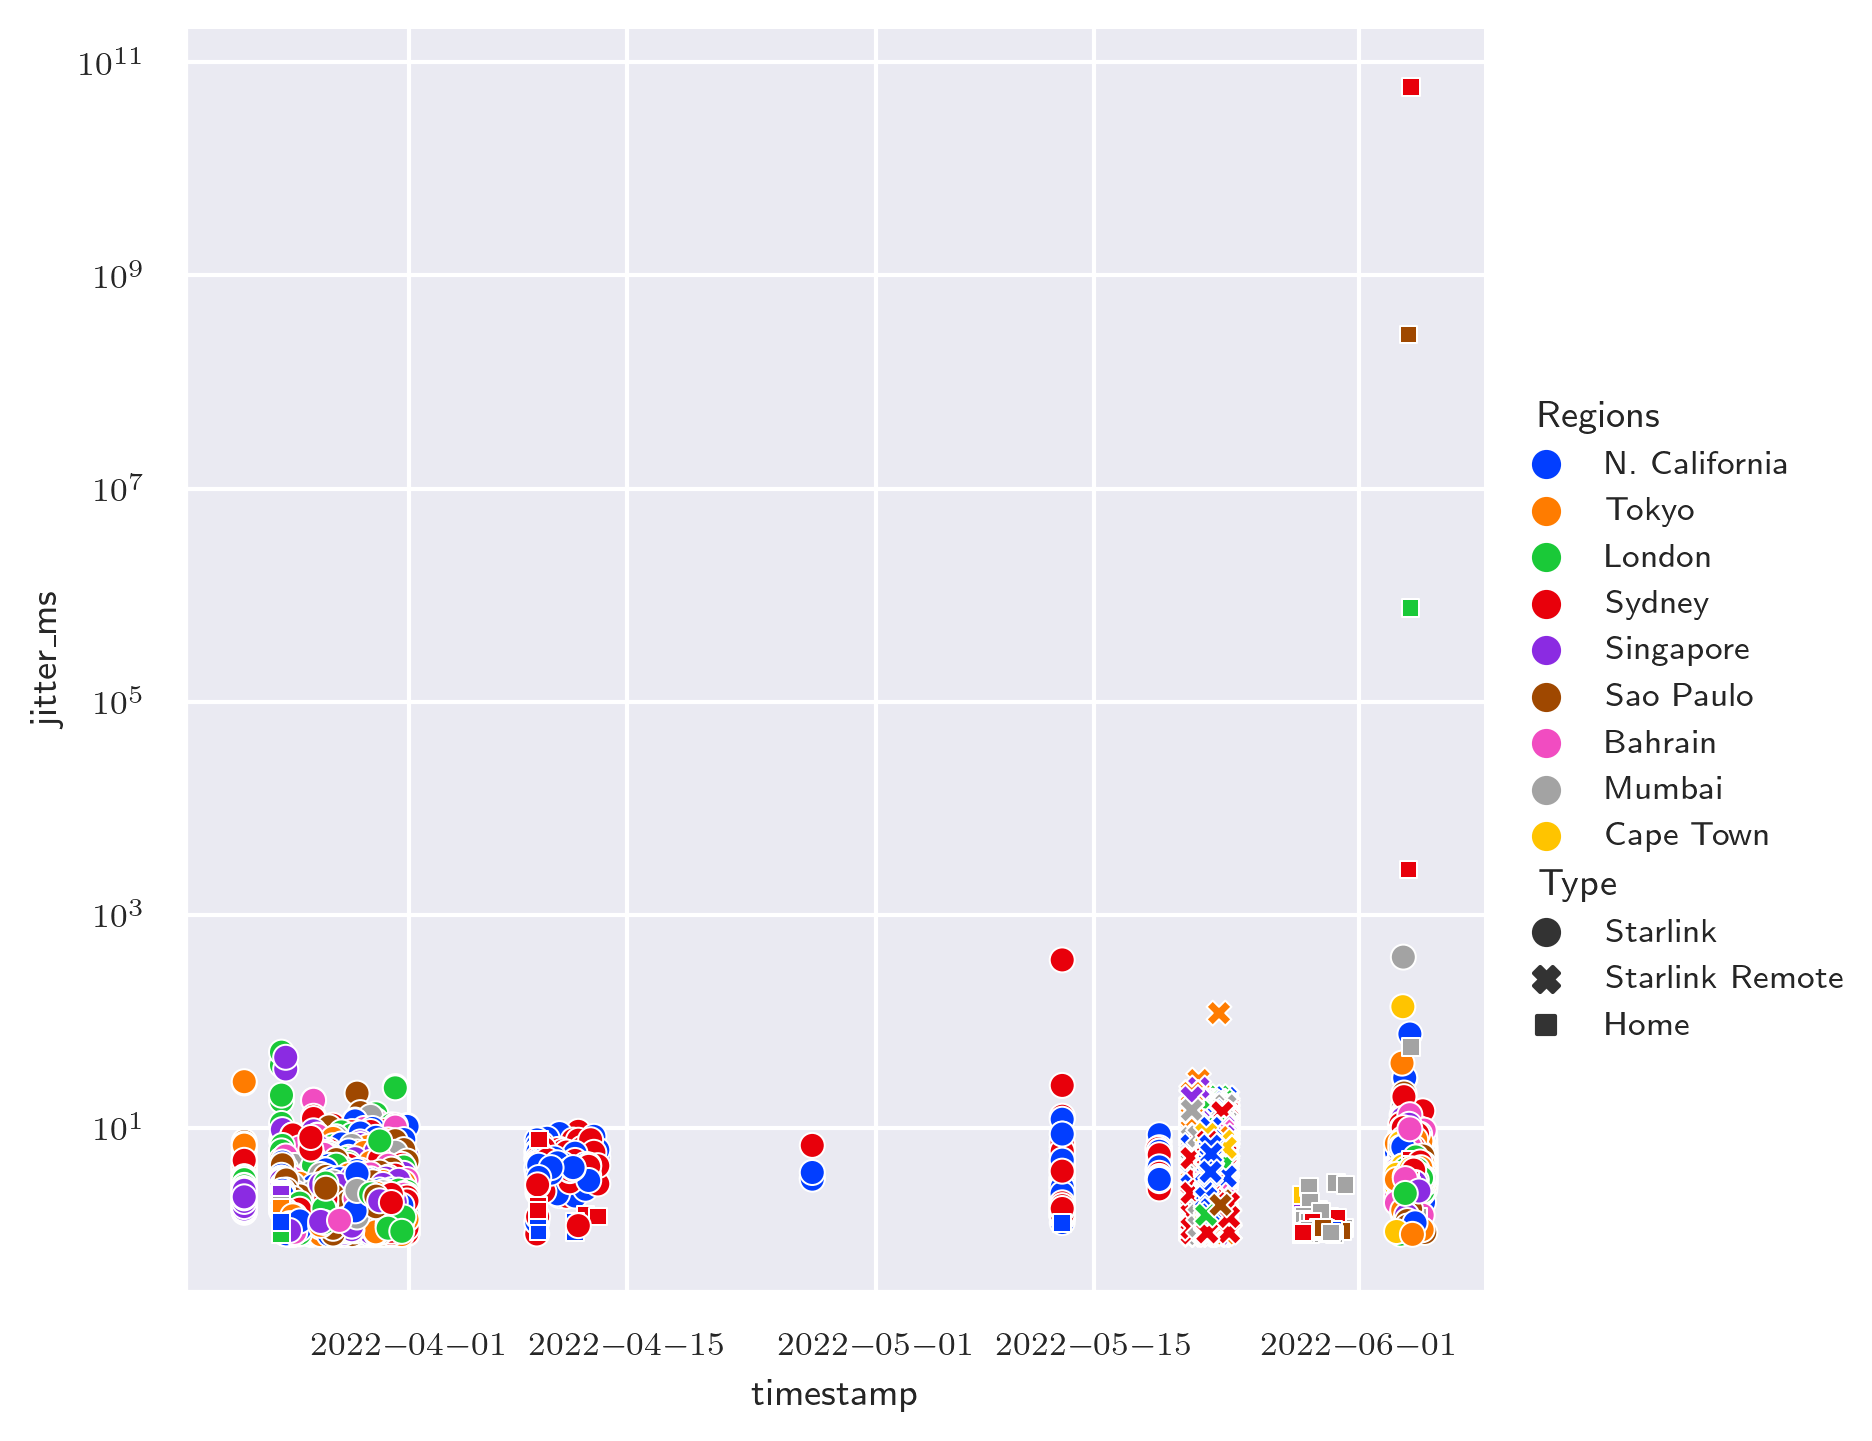

In [136]:
df_home_jitter_out = df_outliers[(df_outliers['jitter_ms'] > 1)]
g_out = sns.relplot(
    data=df_home_jitter_out,
    x='timestamp',
    y='jitter_ms',
    hue=N_REGIONS, hue_order=common.REGION_ORDER,
    style=N_TYPE,
)

g_out.set(yscale='log')

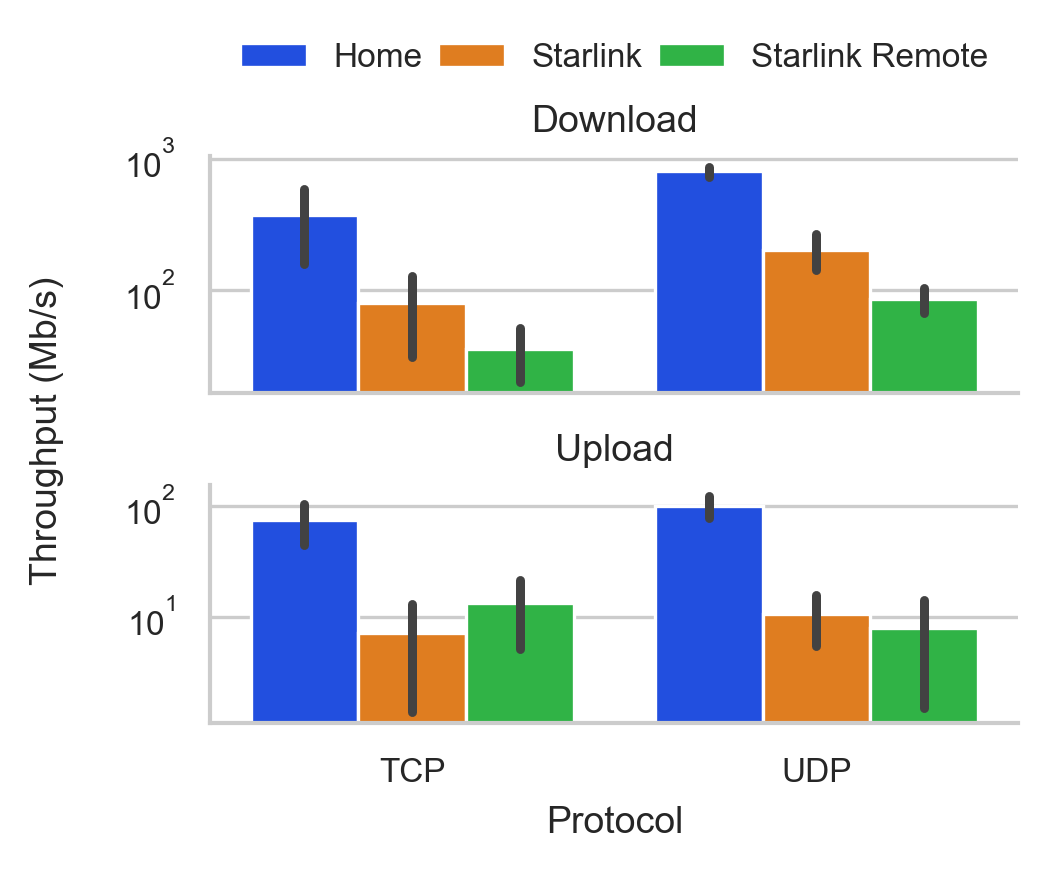

In [81]:
#temp = df_regs.loc['2022-06-03':]
g_avg_small = sns.catplot(data=df_regs_all, row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_PROTOCOL, y='bandwidth', hue=N_TYPE,
                    hue_order=[N_HOME, N_STARLINK, N_STARLINK_REMOTE],
                    #palette=['C3']*3,
                    order=[N_TCP, N_UDP], row_order=[N_DOWN, N_UP],
                    legend=False,
                    kind='bar', ci='sd',
                    height=1.5, aspect=2.3333)

axes = g_avg_small.axes.flatten()

#axes[0].legend(loc='lower left', bbox_to_anchor=(1.01,0), fancybox=True, frameon=False)
axes[0].legend(loc='lower left', bbox_to_anchor=(0,1.22,1,0.2), ncol=3, mode='expand', fancybox=True, frameon=False)
#axes[0].legend(loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode='expand', ncol=3, fancybox=True, frameon=False)
#g_avg_small.figure.autofmt_xdate()
g_avg_small.set_titles(row_template="{row_name}")
g_avg_small.set(ylabel="")
g_avg_small.figure.supylabel("Throughput (Mb/s)", fontsize=9)
g_avg_small.tight_layout()

In [82]:
g_avg_small.savefig(os.path.join(OUTPUT_FOLDER, '2022-06-21_end_throughput_koeye_summary.pdf'), bbox_inches='tight')

In [13]:
sns.plotting_context()

{'font.size': 9.0,
 'axes.labelsize': 9.0,
 'axes.titlesize': 9.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.8,
 'legend.fontsize': 8.0,
 'axes.linewidth': 1.0,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.2000000000000002,
 'lines.markersize': 4.800000000000001,
 'patch.linewidth': 0.8,
 'xtick.major.width': 1.0,
 'ytick.major.width': 1.0,
 'xtick.minor.width': 0.8,
 'ytick.minor.width': 0.8,
 'xtick.major.size': 4.800000000000001,
 'ytick.major.size': 4.800000000000001,
 'xtick.minor.size': 3.2,
 'ytick.minor.size': 3.2,
 'legend.title_fontsize': 9.0}

In [332]:
def diff_table(table):
    df_perc = table.pivot_table(index=[N_PROTOCOL, N_REGIONS], columns=N_TYPE, values='bandwidth')
    df_perc['diff'] = df_perc['Home'] - df_perc['Starlink']
    return df_perc.reset_index().pivot_table(index=N_PROTOCOL, columns=N_REGIONS, values='diff')

#diff_table(df_regs)
#diff_table(df_regs.groupby([N_TYPE, N_PROTOCOL, N_REGIONS]).mean().reset_index())

#df_agg = df_regs.groupby([N_TYPE, N_PROTOCOL, N_REGIONS]).max().reset_index()

#df_agg.pivot_table(index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL], values='bandwidth')
#df_agg = df_regs[df_regs[N_TYPE] == N_STARLINK]
#df_agg = df_agg[df_agg[COL_TRANSF_DIR] == N_DOWN]
#df_agg = df_agg[df_agg[N_PROTOCOL] == N_UDP]
#df_agg = df_agg[df_agg['lost_percent'] == 0]
#df_agg[df_agg['bandwidth'] < 200]

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Protocol,,,,,,,,,
TCP,67.119171,55.834125,108.921917,57.119920,136.162616,81.754842,73.882104,99.681519,105.193350
UDP,317.443595,335.789284,313.196314,310.319257,319.836165,317.893850,296.971091,280.048385,295.448007


In [299]:
#df_avg = df_outliers[df_outliers['bandwidth'] > 0]
#df_avg = df_avg[df_avg[N_THROUGHPUT_OUTLIERS] == False]
#df_avg = df_regs.pivot_table(index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL, COL_TRANSF_DIR], values='bandwidth', aggfunc='count').reindex(common.REGION_ORDER)

df_avg = df_outliers#[df_outliers[N_REGIONS] != 'Sydney']
df_std = df_avg
df_avg = df_avg.pivot_table(
    index=COL_TRANSF_DIR, columns=[N_TYPE, N_PROTOCOL], values='bandwidth',
    aggfunc='mean'
)
df_std = df_std.pivot_table(
    index=COL_TRANSF_DIR, columns=[N_TYPE, N_PROTOCOL], values='bandwidth',
    aggfunc='std'
)
df_out = df_std / df_avg

#styler = df_avg.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, 'all_bandwidth.tex'))
df_out
#df_scale = pd.DataFrame()
#left_comp = N_STARLINK
#right_comp = N_HOME
#df_scale[N_TCP] = df_avg[left_comp][N_TCP] / df_avg[right_comp][N_TCP]
#df_scale[N_UDP] = df_avg[left_comp][N_UDP] / df_avg[right_comp][N_UDP]
#df_scale['R_TCP / R_UDP'] = df_avg[N_STARLINK_REMOTE][N_UDP] / df_avg[N_STARLINK_REMOTE][N_TCP]
#df_scale

Type                    Home            Starlink           Starlink Remote  \
Protocol                 TCP       UDP       TCP       UDP             TCP   
Transfer Direction                                                           
Download            0.579311  0.090226  0.608317  0.306132        0.439718   
Upload              0.404414  0.221139  0.808282  0.489662        0.615931   

Type                          
Protocol                 UDP  
Transfer Direction            
Download            0.208332  
Upload              0.808116

In [277]:
df_outliers[
    (df_outliers[N_TYPE] == N_HOME) &
    (df_outliers[N_REGIONS] == 'Sydney') &
    (df_outliers[N_PROTOCOL] == N_TCP) &
    (df_outliers['bandwidth'] < 200)
].sort_values('timestamp')

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent,Throughput Outliers
294623,2022-01-19 01:55:24.000022016+00:00,148.455179,Sydney,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN,False
295939,2022-01-19 01:55:25.000065024+00:00,150.932930,Sydney,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN,False
302568,2022-01-19 01:55:26.000061952+00:00,159.103829,Sydney,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN,False
299166,2022-01-19 01:55:27.000076032+00:00,155.471983,Sydney,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN,False
294959,2022-01-19 01:55:28.000128+00:00,148.963180,Sydney,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
198053,2022-06-05 03:00:27.000150016+00:00,71.851434,Sydney,TCP,Upload,Home,TCP Home,NaN,NaN,NaN,NaN,False
211253,2022-06-05 03:00:28.000201984+00:00,83.293167,Sydney,TCP,Upload,Home,TCP Home,NaN,NaN,NaN,NaN,False
209498,2022-06-05 03:00:29.000119808+00:00,81.777767,Sydney,TCP,Upload,Home,TCP Home,NaN,NaN,NaN,NaN,False
274009,2022-06-05 03:00:30.000293888+00:00,114.843497,Sydney,TCP,Upload,Home,TCP Home,NaN,NaN,NaN,NaN,False


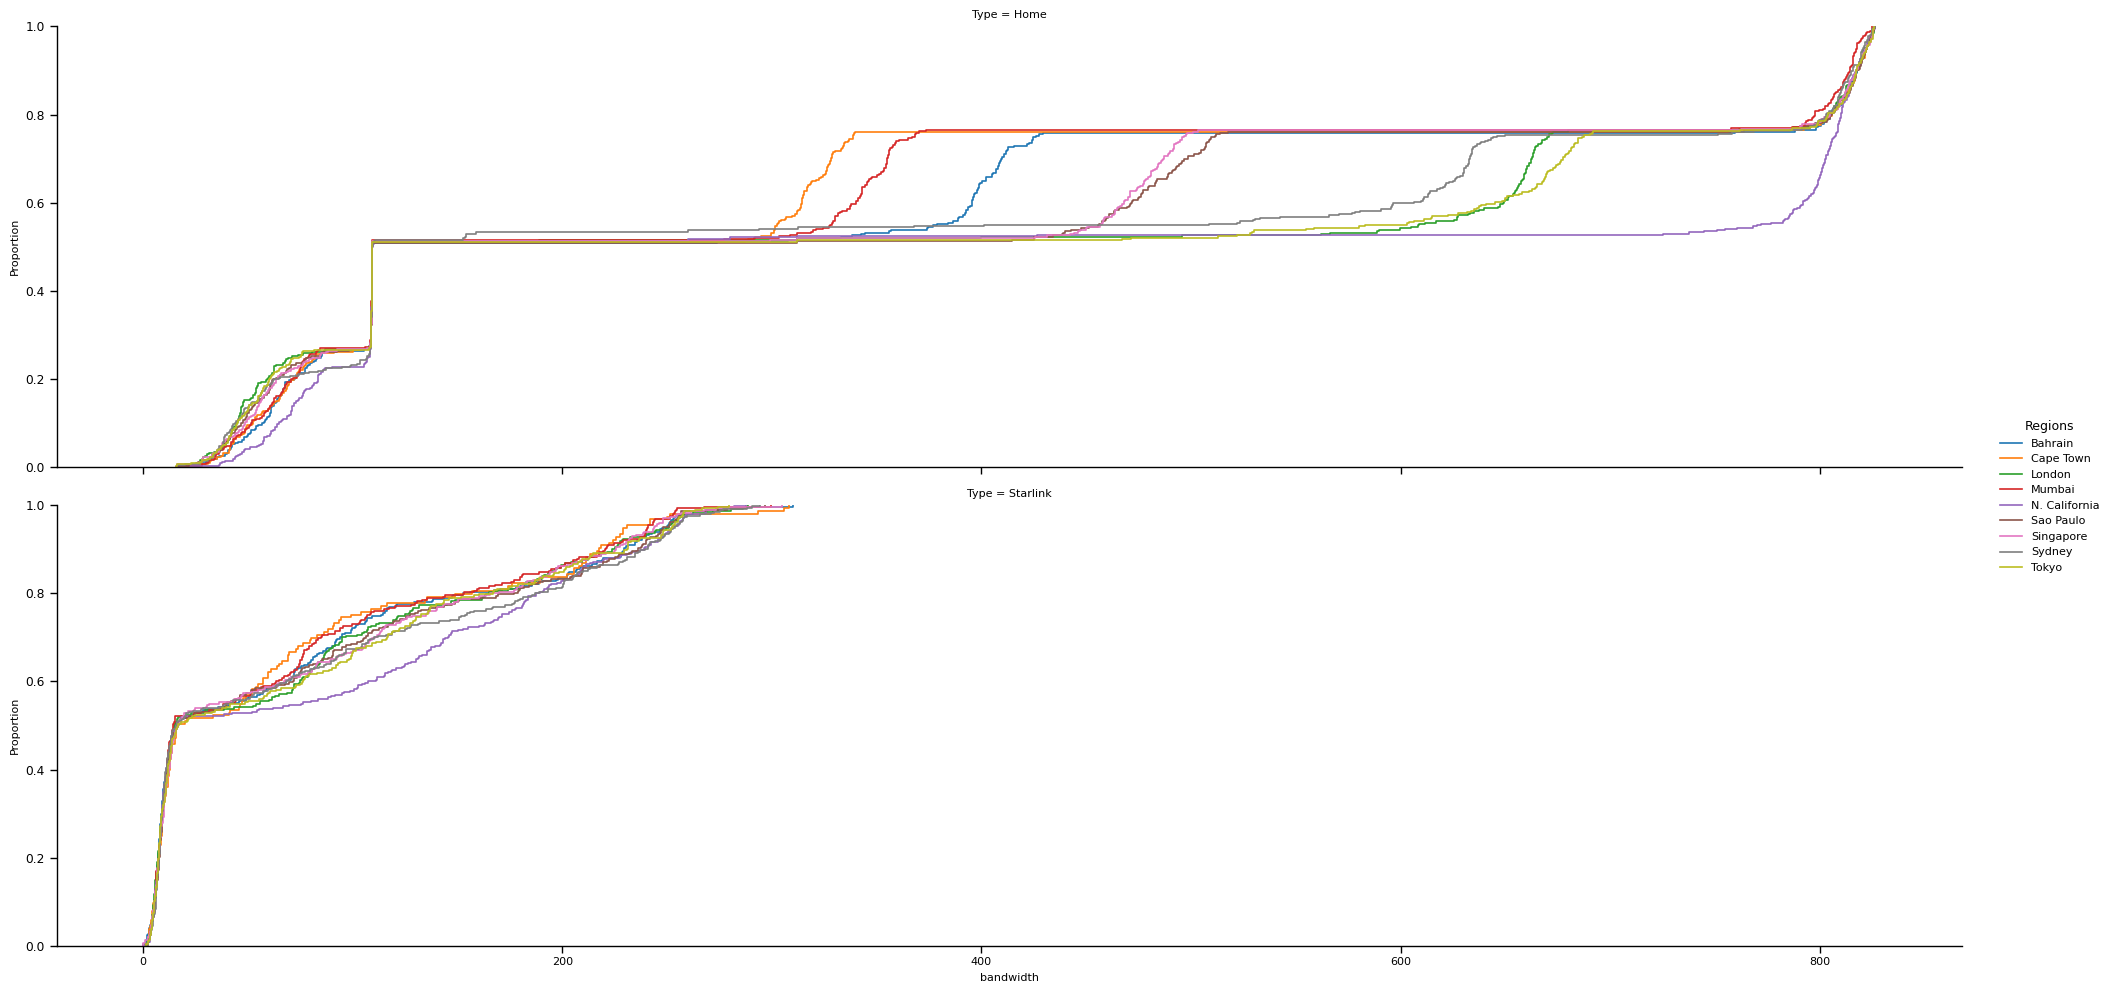

In [135]:
#fig2, ax2 = plt.subplots(figsize=(20,10))
g2 = sns.FacetGrid(data=df_unstacked, row=N_TYPE, hue=N_REGIONS, height=5, aspect=4)
g2.map(sns.ecdfplot, 'bandwidth')
g2.add_legend()
g2.tight_layout()
#fig2.tight_layout()

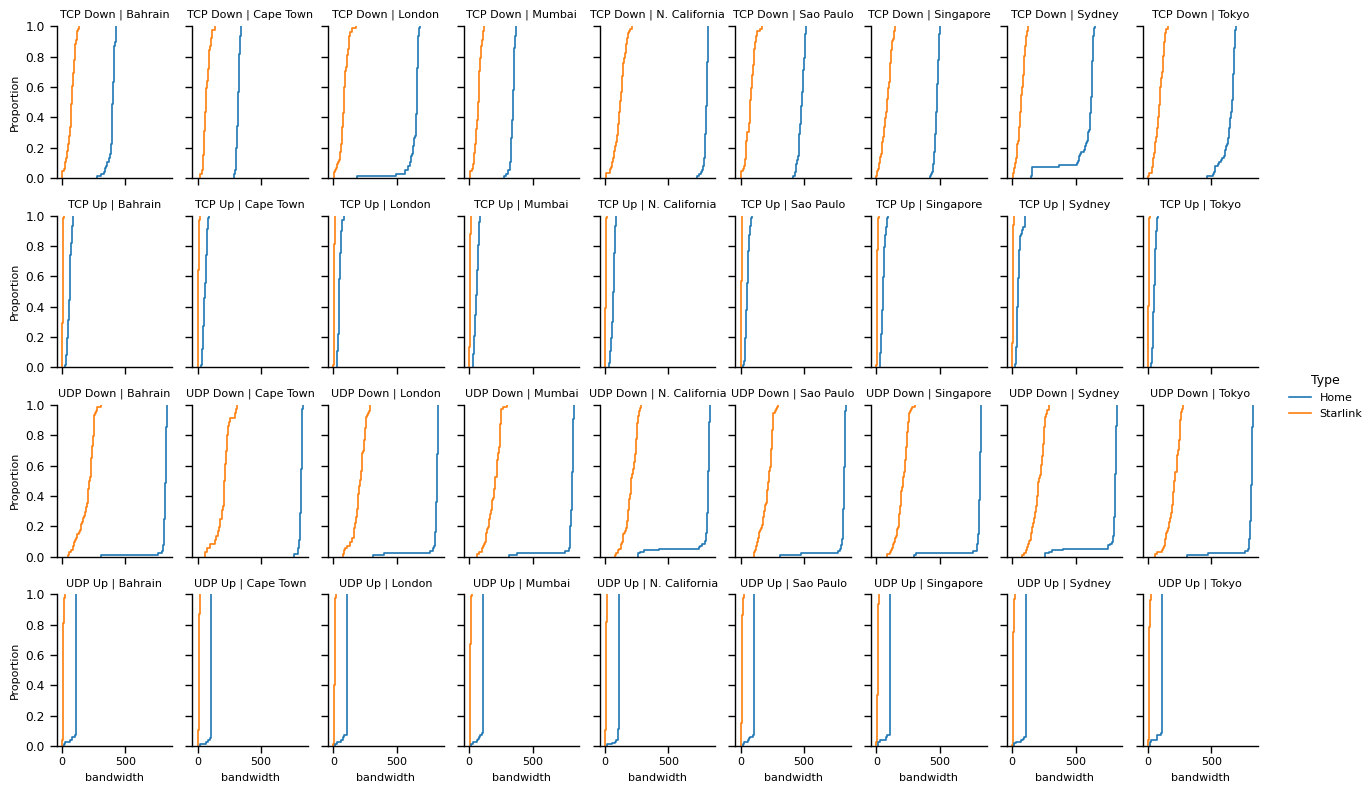

In [136]:
g_hist = sns.displot(
    data=df_unstacked, 
    x='bandwidth', col=N_REGIONS, row=N_PROTOCOL, hue=N_TYPE, kind='ecdf', height=2, aspect=0.716)
g_hist.set_titles(col_template="{col_name}", row_template="{row_name}")
g_hist.tight_layout()

In [150]:
g.savefig(f'output/throughput/throughput.pdf', bbox_inches='tight')
g2.savefig(f'output/throughput/throughput_cdf.pdf', bbox_inches='tight')
#fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
#fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')